# Solution Part:
* Data Understanding
* Data Exploration
* Data Cleaning
* Data Preparation/Feature Engineering
* Model Building
* Model Evaluation

In [1]:
#Import all the libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
#Read the dataset
cars = pd.read_parquet('Customer Database.parquet')
cars_test = pd.read_excel('Test Customer Data.xlsx')
cars_test_original = cars_test.copy()

In [6]:
cars.shape

(3519243, 34)

In [7]:
cars.head()

,Location_Region,VRLOCATION,VRSALEAMT,VRMILEAGE,Vehicle_year,Trim,Series,Vehicle_cylinders,Vehicle_botcolor,Vehicle_doors,Vehicle_trantype,Vehicle_engine,Vehicle_drive,Vehicle_condition_drivable,Vehicle_condition_overall,BodyClass,DriveType,EngineHP,FuelTypePrimary,EngineConfiguration,EngineModel,GVWR,PlantCountry,BasePrice,IsEV,EVType,MarketSegment,SALEDATE_WeekofYearNumber,SALEDATE_MonthofYearNumber,SALEDATE_Quarter,SALEDATE_Year,Model,Make,VRSALEDATE
0,SOUTH,GREENVILLE,4800,161231,2015.0,None,ZVW30L,4.0,GRN,4.0,A,1.8,F,Y,2.0,Hatchback/Liftback/Notchback,4x2,NaN,Gasoline,In-Line,2ZR-FXE+3JM,"Class 1: 6,000 lb or less (2,722 kg or less)",JAPAN,None,1,Hybrid,EV Hatchback,37,9,3,2025,Prius,TOYOTA,20250912
1,WEST,DALLAS,3500,244732,2014.0,Touring/Touring-EL,None,6.0,SIL,4.0,A,3.5,F,None,NaN,Minivan,None,248.0,Gasoline,V-Shaped,J35Z8,"Class 2E: 6,001 - 7,000 lb (2,722 - 3,175 kg)",UNITED STATES (USA),None,0,ICE,Minivan,14,4,2,2025,Odyssey,HONDA,20250401
2,EAST,CHARLESTON,15500,92087,2019.0,Standard,None,4.0,GRY,4.0,A,2.4,F,None,NaN,Sedan/Saloon,4x2,206.0,Gasoline,In-Line,K24W7,"Class 1C: 4,001 - 5,000 lb (1,814 - 2,268 kg)",UNITED STATES (USA),None,0,ICE,Sedan,11,3,1,2025,TLX,ACURA,20250314
3,EAST,CHARLESTON,19600,46553,2021.0,None,SEL FHEV,4.0,WHT,4.0,A,2.5,F,Y,5.0,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,4x2,NaN,Gasoline,In-Line,HEV/PHEV,"Class 1C: 4,001 - 5,000 lb (1,814 - 2,268 kg)",UNITED STATES (USA),None,1,Hybrid,EV SUV,13,3,1,2025,Escape,FORD,20250328
4,NORTH,BADGERSTATE,10000,114800,2017.0,Platinum,None,6.0,BLK,4.0,A,3.5,4,Y,NaN,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,4WD/4-Wheel Drive/4x4,365.0,Gasoline,V-Shaped,3.5L GTDI,"Class 2E: 6,001 - 7,000 lb (2,722 - 3,175 kg)",UNITED STATES (USA),53235.00,0,ICE,SUV 3-Row,5,2,1,2025,Explorer,FORD,20250130


In [8]:
# cars.sort_values(by=['Make', 'Model','Trim','Vehicle_year','Vehicle_cylinders'], ascending=[True, True, True, False, True], inplace=True)
# cars[['Make', 'Model', 'VRSALEAMT', 'VRMILEAGE', 'Vehicle_year', 'Trim', 'Vehicle_cylinders']].head(1000)

Data Exploration

In [9]:
def clean_and_fix_temporal(df):
    df = df.copy()

    # --- sale_date (approx from Year+Month if you have them) ---
    # If you also have day, use it. Otherwise pivot to middle-of-month.
    df["SALEDATE_Year"] = pd.to_numeric(df["SALEDATE_Year"], errors="coerce")
    df["SALEDATE_MonthofYearNumber"] = pd.to_numeric(df["SALEDATE_MonthofYearNumber"], errors="coerce").fillna(6)
    df["sale_date"] = pd.to_datetime(df["VRSALEDATE"].astype(str),format="%Y%m%d", errors="coerce")    
    df['IsEV'] = pd.to_numeric(df["IsEV"])


    # --- Vehicle condition grade: extract number safely ---
    # Works for "Grade 3.5", "3.5", 0.0, etc.
    if "Vehicle_condition_overall" in df.columns:
        vc = df["Vehicle_condition_overall"].astype(str).str.extract(r'(\d+(\.\d+)?)')[0]
        df["Vehicle_condition_overall"] = pd.to_numeric(vc, errors="coerce")

    # --- Numeric coercions you rely on downstream ---
    num_cols = [
        'VRMILEAGE','Vehicle_year','Vehicle_cylinders','Vehicle_doors',
        'Vehicle_engine','Vehicle_condition_overall','EngineHP','BasePrice',
        'SALEDATE_WeekofYearNumber','SALEDATE_MonthofYearNumber','SALEDATE_Quarter',
        'SALEDATE_Year','vehicle_age','mileage_per_year','log_mileage','log_age',
        'drivable_flag','GVWR_class'
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # --- clamp & age at sale ---
    df["Vehicle_year"] = df["Vehicle_year"].clip(1900, 2100)
    df["vehicle_age"] = (df["SALEDATE_Year"] - df["Vehicle_year"]).clip(lower=0)

    # --- mileage hygiene ---
    # cap ridiculous mileage and fix negatives
    df["VRMILEAGE"] = df["VRMILEAGE"].clip(lower=0, upper=df["VRMILEAGE"].quantile(0.9995))

    # --- safe ratios/logs ---
    age_safe = df["vehicle_age"].replace(0, 0.5)
    df["mileage_per_year"] = df["VRMILEAGE"] / age_safe
    df["log_mileage"] = np.log1p(df["VRMILEAGE"])
    df["log_age"] = np.log1p(df["vehicle_age"])

    # --- drivable ---
    df["drivable_flag"] = (df["Vehicle_condition_drivable"] == "Y").astype(np.int8)

    # --- GVWR numeric class extraction (keeps signal, shrinks OHE) ---
    # "Class 1: 6,000 lb..." -> 1
    if "GVWR" in df.columns:
        df["GVWR_class"] = (
            df["GVWR"].astype(str).str.extract(r'Class\s*(\d+)')[0].astype(float)
        )

    # downcast numerics
    for c in df.select_dtypes(include=[np.number]).columns:
        df[c] = pd.to_numeric(df[c], downcast="float")

    return df

In [10]:
cars = clean_and_fix_temporal(cars)
cars_test = clean_and_fix_temporal(cars_test)

In [11]:
cars.dtypes

Location_Region                       object
VRLOCATION                            object
VRSALEAMT                            float32
VRMILEAGE                            float64
Vehicle_year                         float32
Trim                                  object
Series                                object
Vehicle_cylinders                    float32
Vehicle_botcolor                      object
Vehicle_doors                        float32
Vehicle_trantype                      object
Vehicle_engine                       float32
Vehicle_drive                         object
Vehicle_condition_drivable            object
Vehicle_condition_overall            float32
BodyClass                             object
DriveType                             object
EngineHP                             float32
FuelTypePrimary                       object
EngineConfiguration                   object
EngineModel                           object
GVWR                                  object
PlantCount

In [12]:
cars.head()

,Location_Region,VRLOCATION,VRSALEAMT,VRMILEAGE,Vehicle_year,Trim,Series,Vehicle_cylinders,Vehicle_botcolor,Vehicle_doors,Vehicle_trantype,Vehicle_engine,Vehicle_drive,Vehicle_condition_drivable,Vehicle_condition_overall,BodyClass,DriveType,EngineHP,FuelTypePrimary,EngineConfiguration,EngineModel,GVWR,PlantCountry,BasePrice,IsEV,EVType,MarketSegment,SALEDATE_WeekofYearNumber,SALEDATE_MonthofYearNumber,SALEDATE_Quarter,SALEDATE_Year,Model,Make,VRSALEDATE,sale_date,vehicle_age,mileage_per_year,log_mileage,log_age,drivable_flag,GVWR_class
0,SOUTH,GREENVILLE,4800.0,161231.0,2015.0,None,ZVW30L,4.0,GRN,4.0,A,1.8,F,Y,2.0,Hatchback/Liftback/Notchback,4x2,NaN,Gasoline,In-Line,2ZR-FXE+3JM,"Class 1: 6,000 lb or less (2,722 kg or less)",JAPAN,NaN,1.0,Hybrid,EV Hatchback,37.0,9.0,3.0,2025.0,Prius,TOYOTA,20250912,2025-09-12,10.0,16123.100000,11.990600,2.397895,1,1.0
1,WEST,DALLAS,3500.0,244732.0,2014.0,Touring/Touring-EL,None,6.0,SIL,4.0,A,3.5,F,None,NaN,Minivan,None,248.0,Gasoline,V-Shaped,J35Z8,"Class 2E: 6,001 - 7,000 lb (2,722 - 3,175 kg)",UNITED STATES (USA),NaN,0.0,ICE,Minivan,14.0,4.0,2.0,2025.0,Odyssey,HONDA,20250401,2025-04-01,11.0,22248.363636,12.407923,2.484907,0,2.0
2,EAST,CHARLESTON,15500.0,92087.0,2019.0,Standard,None,4.0,GRY,4.0,A,2.4,F,None,NaN,Sedan/Saloon,4x2,206.0,Gasoline,In-Line,K24W7,"Class 1C: 4,001 - 5,000 lb (1,814 - 2,268 kg)",UNITED STATES (USA),NaN,0.0,ICE,Sedan,11.0,3.0,1.0,2025.0,TLX,ACURA,20250314,2025-03-14,6.0,15347.833333,11.430500,1.945910,0,1.0
3,EAST,CHARLESTON,19600.0,46553.0,2021.0,None,SEL FHEV,4.0,WHT,4.0,A,2.5,F,Y,5.0,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,4x2,NaN,Gasoline,In-Line,HEV/PHEV,"Class 1C: 4,001 - 5,000 lb (1,814 - 2,268 kg)",UNITED STATES (USA),NaN,1.0,Hybrid,EV SUV,13.0,3.0,1.0,2025.0,Escape,FORD,20250328,2025-03-28,4.0,11638.250000,10.748368,1.609438,1,1.0
4,NORTH,BADGERSTATE,10000.0,114800.0,2017.0,Platinum,None,6.0,BLK,4.0,A,3.5,4,Y,NaN,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,4WD/4-Wheel Drive/4x4,365.0,Gasoline,V-Shaped,3.5L GTDI,"Class 2E: 6,001 - 7,000 lb (2,722 - 3,175 kg)",UNITED STATES (USA),53235.0,0.0,ICE,SUV 3-Row,5.0,2.0,1.0,2025.0,Explorer,FORD,20250130,2025-01-30,8.0,14350.000000,11.650955,2.197225,1,2.0


In [13]:
cars_numeric = cars.select_dtypes(include=[np.number])

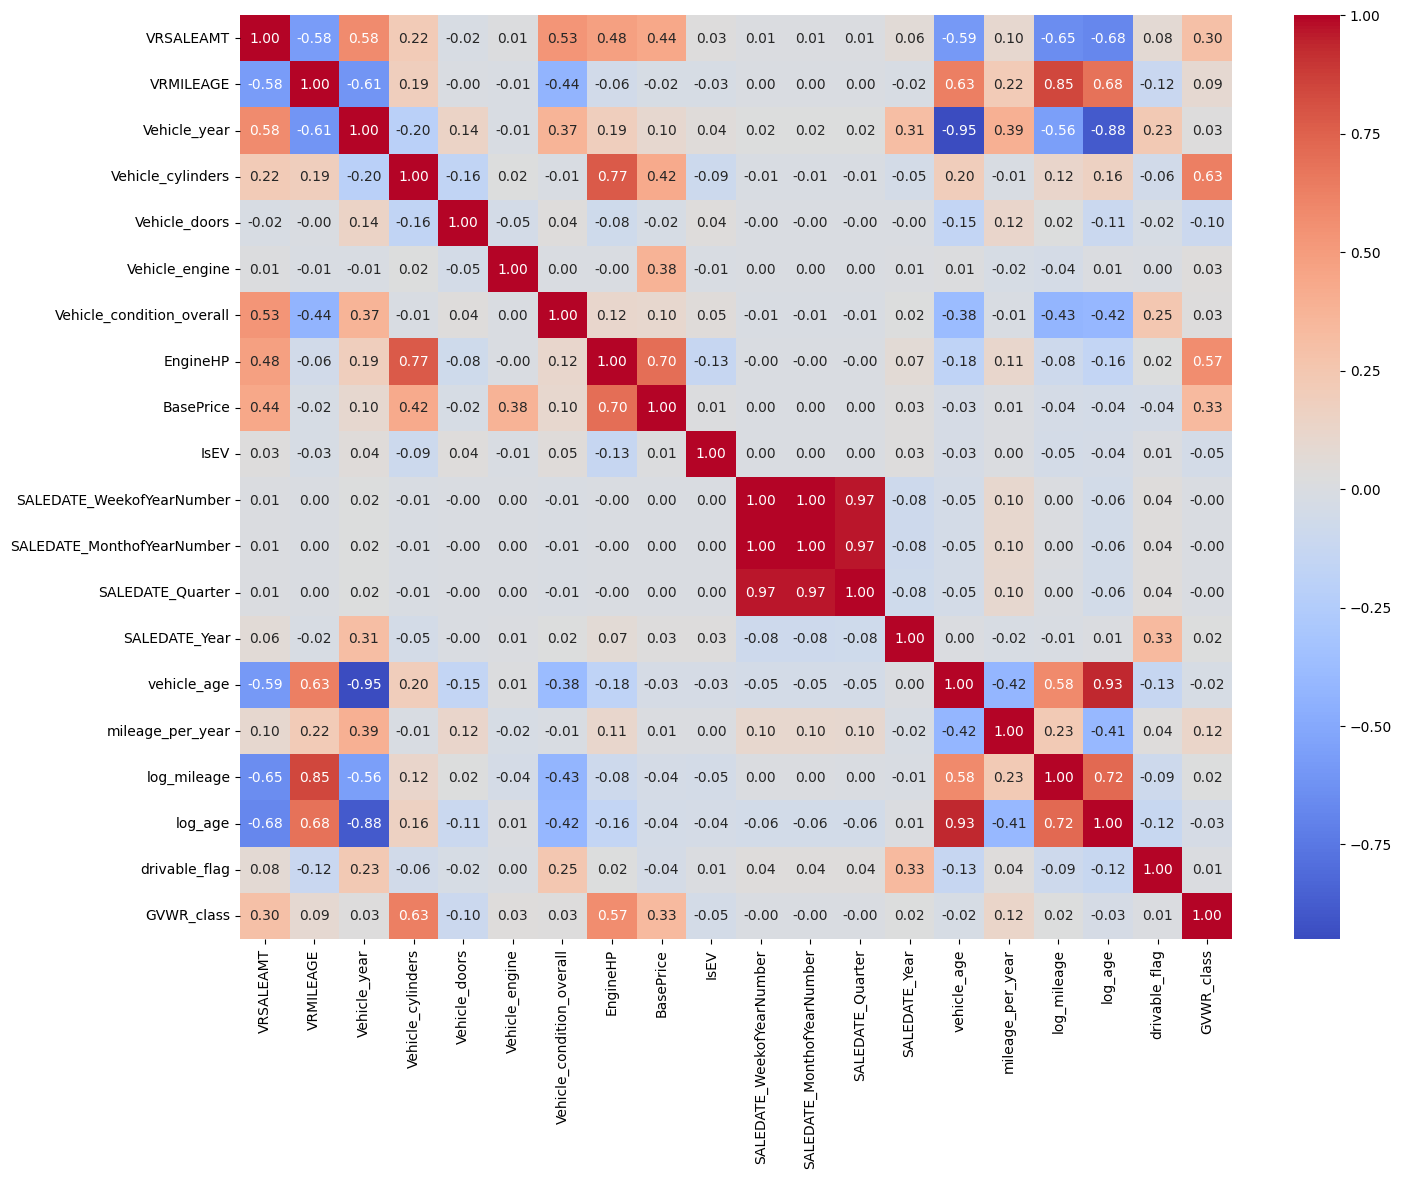

In [14]:
plt.figure(figsize=(16, 12))
sns.heatmap(cars_numeric.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [15]:
#Correlation plot
cor = cars_numeric.corr()
cor

,VRSALEAMT,VRMILEAGE,Vehicle_year,Vehicle_cylinders,Vehicle_doors,Vehicle_engine,Vehicle_condition_overall,EngineHP,BasePrice,IsEV,SALEDATE_WeekofYearNumber,SALEDATE_MonthofYearNumber,SALEDATE_Quarter,SALEDATE_Year,vehicle_age,mileage_per_year,log_mileage,log_age,drivable_flag,GVWR_class
VRSALEAMT,1.000000,-0.575154,0.580099,0.223057,-0.016534,0.011347,0.528147,0.478525,0.439989,0.032762,0.006207,0.006160,0.005933,0.055974,-0.591494,0.098963,-0.646809,-0.681167,0.075041,0.298335
VRMILEAGE,-0.575154,1.000000,-0.606833,0.188696,-0.002800,-0.012601,-0.439066,-0.060583,-0.024057,-0.026767,0.001141,0.001273,0.000954,-0.016931,0.632584,0.220918,0.845345,0.680517,-0.117388,0.088122
Vehicle_year,0.580099,-0.606833,1.000000,-0.203709,0.142593,-0.007496,0.369617,0.191726,0.099899,0.041986,0.019616,0.019246,0.019960,0.309675,-0.949447,0.391594,-0.557894,-0.884067,0.231795,0.027728
Vehicle_cylinders,0.223057,0.188696,-0.203709,1.000000,-0.161944,0.022469,-0.010838,0.772800,0.424008,-0.091227,-0.008065,-0.008011,-0.008027,-0.050104,0.197699,-0.006879,0.124040,0.162674,-0.061403,0.629853
Vehicle_doors,-0.016534,-0.002800,0.142593,-0.161944,1.000000,-0.046751,0.039400,-0.077987,-0.021356,0.040288,-0.001745,-0.001599,-0.001705,-0.002044,-0.150867,0.120108,0.023908,-0.109704,-0.021602,-0.100305
Vehicle_engine,0.011347,-0.012601,-0.007496,0.022469,-0.046751,1.000000,0.001649,-0.004585,0.380202,-0.007230,0.000095,0.000182,0.000678,0.009117,0.010893,-0.021693,-0.036746,0.007874,0.001613,0.034404
Vehicle_condition_overall,0.528147,-0.439066,0.369617,-0.010838,0.039400,0.001649,1.000000,0.115638,0.104556,0.045232,-0.011872,-0.011612,-0.011499,0.018726,-0.381738,-0.007446,-0.427422,-0.415578,0.246847,0.032318
EngineHP,0.478525,-0.060583,0.191726,0.772800,-0.077987,-0.004585,0.115638,1.000000,0.702804,-0.128081,-0.001090,-0.001106,-0.000983,0.069466,-0.179380,0.112230,-0.083639,-0.156343,0.023699,0.569759
BasePrice,0.439989,-0.024057,0.099899,0.424008,-0.021356,0.380202,0.104556,0.702804,1.000000,0.012348,0.000309,0.000441,0.000714,0.031982,-0.034046,0.008636,-0.037874,-0.043260,-0.040913,0.334297
IsEV,0.032762,-0.026767,0.041986,-0.091227,0.040288,-0.007230,0.045232,-0.128081,0.012348,1.000000,0.000949,0.000915,0.001221,0.031966,-0.033587,0.004182,-0.046370,-0.040863,0.009170,-0.047934


In [16]:
cars.isnull().sum()

Location_Region                     0
VRLOCATION                          0
VRSALEAMT                           0
VRMILEAGE                           0
Vehicle_year                        1
Trim                          1159477
Series                        2071744
Vehicle_cylinders               59218
Vehicle_botcolor               552128
Vehicle_doors                  101221
Vehicle_trantype               427059
Vehicle_engine                   8703
Vehicle_drive                  433264
Vehicle_condition_drivable    1438289
Vehicle_condition_overall     1987796
BodyClass                         307
DriveType                      932299
EngineHP                      1855340
FuelTypePrimary                 97132
EngineConfiguration           1316529
EngineModel                   1565157
GVWR                             9047
PlantCountry                     1948
BasePrice                     3046200
IsEV                                0
EVType                              0
MarketSegmen

Data Preparation

In [17]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute   import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error

In [18]:
categorical_cols = cars.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical:", categorical_cols)

Categorical: ['Location_Region', 'VRLOCATION', 'Trim', 'Series', 'Vehicle_botcolor', 'Vehicle_trantype', 'Vehicle_drive', 'Vehicle_condition_drivable', 'BodyClass', 'DriveType', 'FuelTypePrimary', 'EngineConfiguration', 'EngineModel', 'GVWR', 'PlantCountry', 'EVType', 'MarketSegment', 'Model', 'Make', 'VRSALEDATE']


In [19]:
# remove engine from your list of categoricals...
categorical_feats = [
    'Location_Region', 'VRLOCATION', 'Trim', 'Series', 'Vehicle_botcolor', 'Vehicle_trantype', 'Vehicle_drive', 
    'Vehicle_condition_drivable', 'BodyClass', 'DriveType', 'FuelTypePrimary', 'EngineConfiguration', 'EngineModel', 
    'GVWR', 'PlantCountry', 'IsEV', 'EVType', 'MarketSegment', 'Model', 'Make'
]
# …and add it into numeric_feats
numeric_feats = [
    'VRMILEAGE','Vehicle_year','Vehicle_cylinders','Vehicle_doors','Vehicle_engine',
    'Vehicle_condition_overall','EngineHP','BasePrice','SALEDATE_WeekofYearNumber','SALEDATE_MonthofYearNumber',
    'SALEDATE_Quarter','SALEDATE_Year','vehicle_age','mileage_per_year','log_mileage','log_age',
    'drivable_flag','GVWR_class'
]


In [20]:
from scipy.stats import skew
skewness = skew(cars['Vehicle_condition_overall'].dropna())
print("Skewness:", skewness)

Skewness: -0.31964969635009766


In [21]:
X_external = cars_test[numeric_feats + categorical_feats]

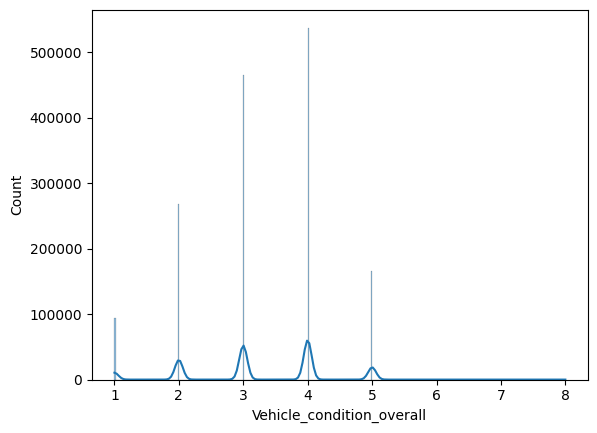

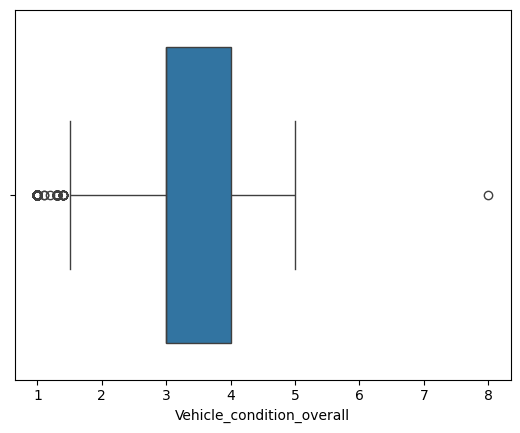

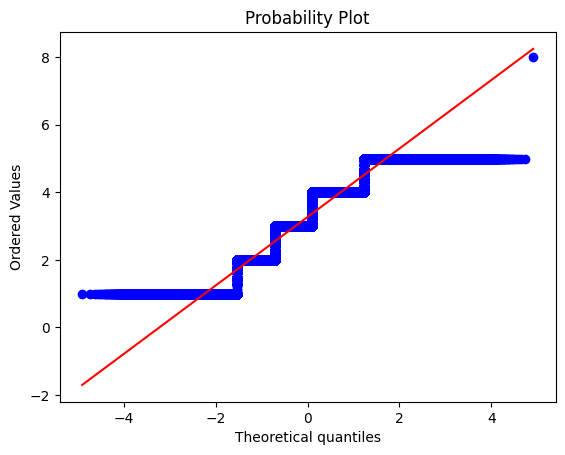

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.histplot(cars['Vehicle_condition_overall'], kde=True)
plt.show()

sns.boxplot(x=cars['Vehicle_condition_overall'])
plt.show()

stats.probplot(cars['Vehicle_condition_overall'].dropna(), dist="norm", plot=plt)
plt.show()

In [23]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale',   StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown', add_indicator=True)),
    ('ohe',      OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_feats),
    ('cat', cat_pipe, categorical_feats),
], remainder='drop', sparse_threshold=1.0)

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [25]:
# ensure sale_date exists and is datetime
assert "sale_date" in cars.columns, "sale_date missing—did you run clean_and_fix_temporal()?"
assert np.issubdtype(cars["sale_date"].dtype, np.datetime64), "sale_date must be datetime"

# Sort & split (as you already do)
cars = cars.dropna(subset=["sale_date"]).sort_values("sale_date")
cut_time   = cars["sale_date"].quantile(0.90)
train_mask = cars["sale_date"] < cut_time
test_mask  = ~train_mask

# Build X/y WITHOUT sale_date
X_train = cars.loc[train_mask, numeric_feats + categorical_feats]
y_train = cars.loc[train_mask, "VRSALEAMT"]
X_test  = cars.loc[test_mask,  numeric_feats + categorical_feats]
y_test  = cars.loc[test_mask,  "VRSALEAMT"]

# ✅ Print date ranges from the source df, not from X_* (sale_date isn't a feature)
print("Train range:", cars.loc[train_mask, "sale_date"].min(), "→", cars.loc[train_mask, "sale_date"].max())
print("Test range :", cars.loc[test_mask,  "sale_date"].min(),  "→", cars.loc[test_mask,  "sale_date"].max())
print("Train size :", len(X_train))
print("Test size  :", len(X_test))

Train range: 2019-07-05 00:00:00 → 2025-05-20 00:00:00
Test range : 2025-05-21 00:00:00 → 2025-11-07 00:00:00
Train size : 3167151
Test size  : 352092


In [26]:
# 4. Helper to build a full pipeline + extract coef names
def make_model_pipeline(model, poly=False):
    steps = []
    if poly:
        # expand numeric features to polynomial degree 2
        steps.append(('poly', PolynomialFeatures(degree=2, include_bias=False)))
    steps.append(('preproc', preprocessor))
    steps.append(('reg', model))
    return Pipeline(steps)

def get_feature_names(pipeline):
    """
    After fitting, get the transformed feature names in order, so you can map back to coefficients.
    Requires sklearn ≥ 1.0 for ColumnTransformer.get_feature_names_out.
    """
    # name from the 'preproc' step
    feat_names = pipeline.named_steps['preproc'].get_feature_names_out()
    if 'poly' in pipeline.named_steps:
        # if polynomial, get names from poly step
        feat_names = pipeline.named_steps['poly'].get_feature_names_out(feat_names)
    return feat_names

In [27]:
from sklearn.compose import TransformedTargetRegressor

def with_log_target(pipeline_or_estimator):
    return TransformedTargetRegressor(
        regressor=pipeline_or_estimator,
        func=np.log1p,      # y' = log(1 + y)
        inverse_func=np.expm1  # y = exp(y') - 1
    )

XGBoost

In [28]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score

In [29]:
# 1) Choose which categoricals to target-encode (high cardinality)
high_card = ["Model","Trim","Series","EngineModel","VRLOCATION"]
high_card = [c for c in high_card if c in X_train.columns]

In [30]:
# 2) Low-card categoricals = original list minus the high-card ones
low_card_cats = [c for c in categorical_feats if c not in high_card]

In [31]:
# 3) Leakage-safe OOF target encoding helper
from sklearn.model_selection import KFold

def oof_target_encode(train_df, test_df, col, target, n_splits=5, smoothing=50):
    """
    Returns (te_train, te_test) for column `col` using leakage-safe OOF means with smoothing.
    """
    global_mean = train_df[target].mean()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    te_train = pd.Series(np.nan, index=train_df.index, dtype=float)

    for tr_idx, val_idx in kf.split(train_df):
        tr = train_df.iloc[tr_idx]
        stats = tr.groupby(col)[target].agg(['count','mean'])
        stats["te"] = (stats["count"]*stats["mean"] + smoothing*global_mean) / (stats["count"] + smoothing)
        te_train.iloc[val_idx] = train_df.iloc[val_idx][col].map(stats["te"]).fillna(global_mean)

    # Fit on full train to transform test
    stats_full = train_df.groupby(col)[target].agg(['count','mean'])
    stats_full["te"] = (stats_full["count"]*stats_full["mean"] + smoothing*global_mean) / (stats_full["count"] + smoothing)
    te_test = test_df[col].map(stats_full["te"]).fillna(global_mean)

    return te_train.astype('float32'), te_test.astype('float32')

In [32]:
# 4) Apply OOF TE to train/test AND also prep a transformer for your external set
for col in high_card:
    tr_te, te_te = oof_target_encode(
        train_df=pd.concat([X_train, y_train], axis=1),
        test_df=X_test,
        col=col,
        target="VRSALEAMT"
    )
    X_train[f"te__{col}"] = tr_te.values
    X_test[f"te__{col}"]  = te_te.values

In [33]:
# 5) Do the same transform for your external data (cars_test / X_external)
#    Use ONLY training data stats to encode external
if 'X_external' in globals():
    # reuse the same function but with train_df from the training split
    train_w_target = pd.concat([X_train.drop(columns=[c for c in X_train.columns if c.startswith("te__")], errors='ignore'),
                                y_train], axis=1)
    for col in high_card:
        tr_te_dummy, te_ext = oof_target_encode(
            train_df=train_w_target.rename(columns={"VRSALEAMT": "VRSALEAMT"}),
            test_df=X_external,
            col=col,
            target="VRSALEAMT"
        )
        X_external[f"te__{col}"] = te_ext.values

In [34]:
# 6) Update your feature lists:
#    - Drop high-card originals from categorical_feats (OHE won’t touch them)
#    - Add the new TE columns to numeric_feats (they’re numeric now)
categorical_feats = [c for c in categorical_feats if c in X_train.columns and c not in high_card]
te_cols = [f"te__{c}" for c in high_card]
numeric_feats = list(dict.fromkeys(list(numeric_feats) + te_cols))  # de-dup while preserving order

In [35]:
# 7) Rebuild the preprocessor to OHE ONLY the remaining low-card categoricals
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])  # no scaler

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown', add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_feats),
    ('cat', cat_pipe, categorical_feats),
], remainder='drop', sparse_threshold=1.0)

In [36]:
num_cols = X_train.select_dtypes(include=[np.number]).columns
X_train[num_cols] = X_train[num_cols].astype('float32')
X_test[num_cols]  = X_test[num_cols].astype('float32')
X_external[num_cols]  = X_external[num_cols].astype('float32')

In [ ]:
import optuna
import numpy as np
import os
import scipy.sparse as sp
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone

# ===== USER KNOBS =====
N_TRIALS = 120
TIME_BUDGET_SECONDS = None
N_SPLITS = 3
FOLD_SAMPLE_FRAC = 0.5     # tune on ~35% of each fold; set to 1.0 if you can afford it
USE_GPU = False             # True if you have CUDA; uses 'gpu_hist'
LOG_TARGET = True
XGB_THREADS = max(1, os.cpu_count() // 2)
# ======================

def _fmt_params(d):
    out = {}
    for k, v in d.items():
        out[k] = float(f"{v:.5g}") if isinstance(v, float) else v
    return out

def _chronologically_sorted(X, y):
    assert "sale_date" in X.columns, "Need sale_date for time-aware splits."
    order = np.argsort(X["sale_date"].values)
    Xs = X.iloc[order].reset_index(drop=True)
    ys = y.iloc[order].reset_index(drop=True)
    return Xs, ys

# 1) Build a parallel sale-date Series for the training window
#    (use whatever your true train mask came from)
sale_dates_train = cars.loc[train_mask, "sale_date"]

# If your sale_date is not datetime (e.g., integers like 20250101), coerce it:
if not np.issubdtype(sale_dates_train.dtype, np.datetime64):
    # try to convert 'YYYYMMDD' ints/strings to datetime
    sale_dates_train = pd.to_datetime(sale_dates_train.astype(str), format="%Y%m%d", errors="coerce")

# 2) Helper that sorts X/y by an external sale-date Series
def _chronologically_sorted(X, y, sale_dates):
    order = np.argsort(sale_dates.values)   # NaT will go last; fine for CV
    Xs = X.iloc[order].reset_index(drop=True)
    ys = y.iloc[order].reset_index(drop=True)
    return Xs, ys

# 3) Sort once up-front (sale_date is NOT included in model features)
X_train_sorted, y_train_sorted = _chronologically_sorted(X_train, y_train, sale_dates_train)

# Optional: small helper to randomly sample each training fold
def _subset_idx(idx, frac, seed):
    if frac >= 1.0: 
        return idx
    rng = np.random.default_rng(seed)
    take = int(len(idx) * frac)
    return np.array(idx)[rng.choice(len(idx), size=take, replace=False)]

def objective(trial):
    # ---------- Search space tuned for ~4M rows ----------
    params = dict(
        objective="reg:squarederror",
        eval_metric="rmse",
        tree_method="gpu_hist" if USE_GPU else "hist",
        grow_policy="lossguide",
        # use leaves instead of depth; depth ignored when lossguide
        max_depth=0,
        max_leaves=trial.suggest_int("max_leaves", 512, 4096, log=True),
        max_bin=trial.suggest_int("max_bin", 128, 512, log=True),
        learning_rate=trial.suggest_float("learning_rate", 0.02, 0.12, log=True),
        min_child_weight=trial.suggest_int("min_child_weight", 20, 200),
        gamma=trial.suggest_float("gamma", 0.0, 10.0),
        # stronger regularization ranges for big data
        reg_alpha=trial.suggest_float("reg_alpha", 1e-8, 50.0, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-2, 300.0, log=True),
        subsample=trial.suggest_float("subsample", 0.7, 0.9),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 0.9),
        colsample_bynode=trial.suggest_float("colsample_bynode", 0.5, 0.9),
        # threading/verbosity
        nthread=XGB_THREADS,
        verbosity=0,
    )
    num_boost_round = trial.suggest_int("n_estimators", 3000, 12000)  # early stopping will truncate

    tscv = TimeSeriesSplit(n_splits=N_SPLITS, gap=7)
    rmse_scores = []

    for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_train_sorted), start=1):
        # Optionally sample each training fold to save time/RAM
        tr_idx_sub = _subset_idx(tr_idx, FOLD_SAMPLE_FRAC, seed=42 + fold)

        X_tr_raw = X_train_sorted.iloc[tr_idx_sub]
        y_tr_raw = y_train_sorted.iloc[tr_idx_sub]
        X_val_raw = X_train_sorted.iloc[val_idx]
        y_val_raw = y_train_sorted.iloc[val_idx]

        # Fit preprocessor per fold (NO leakage), transform to sparse
        preproc = clone(preprocessor).fit(X_tr_raw, y_tr_raw)
        X_tr = preproc.transform(X_tr_raw)
        X_val = preproc.transform(X_val_raw)

        # Ensure sparse CSR float32; DO NOT densify
        if not sp.issparse(X_tr):
            X_tr = sp.csr_matrix(X_tr)
        if not sp.issparse(X_val):
            X_val = sp.csr_matrix(X_val)
        X_tr = X_tr.astype(np.float32)
        X_val = X_val.astype(np.float32)

        # Log target if desired
        y_tr = np.log1p(y_tr_raw.values).astype(np.float32) if LOG_TARGET else y_tr_raw.values.astype(np.float32)
        y_val = np.log1p(y_val_raw.values).astype(np.float32) if LOG_TARGET else y_val_raw.values.astype(np.float32)

        dtr  = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)

        booster = xgb.train(
            params,
            dtrain=dtr,
            num_boost_round=num_boost_round,
            evals=[(dval, "valid")],
            callbacks=[xgb.callback.EarlyStopping(rounds=300, save_best=True)],
            verbose_eval=False
        )

        # Predict (already on the best iteration)
        y_pred = booster.inplace_predict(X_val)
        # Evaluate on original scale
        if LOG_TARGET:
            y_pred_eval = np.expm1(y_pred)
            y_val_eval = np.expm1(y_val)
        else:
            y_pred_eval = y_pred
            y_val_eval = y_val

        rmse = float(np.sqrt(np.mean((y_val_eval - y_pred_eval) ** 2)))
        rmse_scores.append(rmse)

        trial.report(-rmse, step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return -float(np.mean(rmse_scores))  # maximize negative RMSE

# ---- Sampler & pruner ----
sampler = optuna.samplers.TPESampler(
    seed=42, n_startup_trials=10, n_ei_candidates=12, multivariate=True, group=True
)
pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)

study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
study.optimize(
    objective,
    n_trials=N_TRIALS if TIME_BUDGET_SECONDS is None else None,
    timeout=TIME_BUDGET_SECONDS,
    n_jobs=1,
    show_progress_bar=True
)

print("\n--- OPTUNA COMPLETE ---")
print(f"Best mean -RMSE: {-study.best_value:.6f}")
print("Best params:")
for k, v in _fmt_params(study.best_params).items():
    print(f"  {k}: {v}")

[I 2025-11-17 23:36:41,805] A new study created in memory with name: no-name-40ef6f16-085d-43a1-bbbc-23d4b5df54c7
Best trial: 0. Best value: -4541.76:   1%|          | 1/120 [07:19<14:31:12, 439.26s/it]

[I 2025-11-17 23:44:01,062] Trial 0 finished with value: -4541.757405598958 and parameters: {'max_leaves': 1115, 'max_bin': 479, 'learning_rate': 0.07423898007815308, 'min_child_weight': 128, 'gamma': 1.5601864044243652, 'reg_alpha': 3.2582632766541835e-07, 'reg_lambda': 0.018198993697268222, 'subsample': 0.8732352291549871, 'colsample_bytree': 0.7803345035229626, 'colsample_bynode': 0.7832290311184182, 'n_estimators': 3185}. Best is trial 0 with value: -4541.757405598958.


Best trial: 1. Best value: -4510.75:   2%|▏         | 2/120 [22:38<23:39:15, 721.66s/it]

[I 2025-11-17 23:59:20,404] Trial 1 finished with value: -4510.746826171875 and parameters: {'max_leaves': 3848, 'max_bin': 406, 'learning_rate': 0.029259165815356234, 'min_child_weight': 52, 'gamma': 1.8340450985343382, 'reg_alpha': 8.92969012710658e-06, 'reg_lambda': 2.235620964803637, 'subsample': 0.7863890037284231, 'colsample_bytree': 0.6873687420594126, 'colsample_bynode': 0.7447411578889518, 'n_estimators': 4255}. Best is trial 1 with value: -4510.746826171875.


Best trial: 1. Best value: -4510.75:   2%|▎         | 3/120 [23:57<13:55:13, 428.32s/it]

[I 2025-11-18 00:00:39,639] Trial 2 pruned. 


Best trial: 3. Best value: -4509.27:   3%|▎         | 4/120 [37:39<18:48:28, 583.69s/it]

[I 2025-11-18 00:14:21,517] Trial 3 finished with value: -4509.26904296875 and parameters: {'max_leaves': 3683, 'max_bin': 489, 'learning_rate': 0.08513054287953295, 'min_child_weight': 75, 'gamma': 0.9767211400638387, 'reg_alpha': 0.043286811818165793, 'reg_lambda': 0.9345791438428561, 'subsample': 0.7244076469689558, 'colsample_bytree': 0.748553073033381, 'colsample_bynode': 0.5137554084460874, 'n_estimators': 11184}. Best is trial 3 with value: -4509.26904296875.


Best trial: 3. Best value: -4509.27:   4%|▍         | 5/120 [39:04<12:53:42, 403.67s/it]

[I 2025-11-18 00:15:46,001] Trial 4 pruned. 


Best trial: 3. Best value: -4509.27:   5%|▌         | 6/120 [41:35<10:04:08, 317.97s/it]

[I 2025-11-18 00:18:17,615] Trial 5 pruned. 


Best trial: 3. Best value: -4509.27:   6%|▌         | 7/120 [42:39<7:22:31, 234.96s/it] 

[I 2025-11-18 00:19:21,682] Trial 6 pruned. 


Best trial: 3. Best value: -4509.27:   7%|▋         | 8/120 [44:03<5:48:54, 186.91s/it]

[I 2025-11-18 00:20:45,714] Trial 7 pruned. 


Best trial: 3. Best value: -4509.27:   8%|▊         | 9/120 [44:58<4:29:16, 145.56s/it]

[I 2025-11-18 00:21:40,327] Trial 8 pruned. 


Best trial: 3. Best value: -4509.27:   8%|▊         | 10/120 [45:46<3:31:25, 115.32s/it]

[I 2025-11-18 00:22:27,948] Trial 9 pruned. 


Best trial: 10. Best value: -4246.75:   9%|▉         | 11/120 [55:17<7:43:02, 254.89s/it]

[I 2025-11-18 00:31:59,285] Trial 10 finished with value: -4246.751627604167 and parameters: {'max_leaves': 2067, 'max_bin': 253, 'learning_rate': 0.07684571396601124, 'min_child_weight': 39, 'gamma': 0.18214063494642563, 'reg_alpha': 0.07865572541341789, 'reg_lambda': 16.23370163392528, 'subsample': 0.7394689480928824, 'colsample_bytree': 0.772607298088942, 'colsample_bynode': 0.5805576335981364, 'n_estimators': 8584}. Best is trial 10 with value: -4246.751627604167.


Best trial: 10. Best value: -4246.75:  10%|█         | 12/120 [56:10<5:48:19, 193.52s/it]

[I 2025-11-18 00:32:52,443] Trial 11 pruned. 


Best trial: 10. Best value: -4246.75:  11%|█         | 13/120 [57:58<4:58:53, 167.60s/it]

[I 2025-11-18 00:34:40,412] Trial 12 pruned. 


Best trial: 10. Best value: -4246.75:  12%|█▏        | 14/120 [59:47<4:24:30, 149.72s/it]

[I 2025-11-18 00:36:28,810] Trial 13 pruned. 


Best trial: 10. Best value: -4246.75:  12%|█▎        | 15/120 [1:01:09<3:46:23, 129.37s/it]

[I 2025-11-18 00:37:51,024] Trial 14 pruned. 


Best trial: 10. Best value: -4246.75:  13%|█▎        | 16/120 [1:15:46<10:14:22, 354.45s/it]

[I 2025-11-18 00:52:28,155] Trial 15 pruned. 


Best trial: 10. Best value: -4246.75:  14%|█▍        | 17/120 [1:16:36<7:31:26, 262.98s/it] 

[I 2025-11-18 00:53:18,415] Trial 16 pruned. 


Best trial: 10. Best value: -4246.75:  15%|█▌        | 18/120 [1:24:47<9:23:36, 331.53s/it]

[I 2025-11-18 01:01:29,528] Trial 17 pruned. 


Best trial: 10. Best value: -4246.75:  16%|█▌        | 19/120 [1:26:04<7:09:13, 254.98s/it]

[I 2025-11-18 01:02:46,190] Trial 18 pruned. 


Best trial: 10. Best value: -4246.75:  17%|█▋        | 20/120 [1:35:39<9:45:00, 351.01s/it]

[I 2025-11-18 01:12:21,005] Trial 19 finished with value: -4300.583658854167 and parameters: {'max_leaves': 2118, 'max_bin': 426, 'learning_rate': 0.10430217673569728, 'min_child_weight': 112, 'gamma': 0.31143189206897737, 'reg_alpha': 0.0003027903201445594, 'reg_lambda': 0.024386292746248733, 'subsample': 0.7128591520406812, 'colsample_bytree': 0.6847959701454301, 'colsample_bynode': 0.5650980903370941, 'n_estimators': 10591}. Best is trial 10 with value: -4246.751627604167.


Best trial: 10. Best value: -4246.75:  18%|█▊        | 21/120 [1:36:46<7:18:48, 265.94s/it]

[I 2025-11-18 01:13:28,615] Trial 20 pruned. 


Best trial: 10. Best value: -4246.75:  18%|█▊        | 22/120 [1:38:17<5:48:32, 213.39s/it]

[I 2025-11-18 01:14:59,453] Trial 21 pruned. 


Best trial: 10. Best value: -4246.75:  19%|█▉        | 23/120 [1:47:20<8:24:56, 312.33s/it]

[I 2025-11-18 01:24:02,566] Trial 22 finished with value: -4389.181233723958 and parameters: {'max_leaves': 2622, 'max_bin': 393, 'learning_rate': 0.08512771165602848, 'min_child_weight': 42, 'gamma': 0.925306323171236, 'reg_alpha': 5.0350929116878775e-05, 'reg_lambda': 0.10719601744898184, 'subsample': 0.7443898909456476, 'colsample_bytree': 0.6534950458917355, 'colsample_bynode': 0.6293306620017138, 'n_estimators': 10206}. Best is trial 10 with value: -4246.751627604167.


Best trial: 10. Best value: -4246.75:  20%|██        | 24/120 [1:49:31<6:52:24, 257.76s/it]

[I 2025-11-18 01:26:13,020] Trial 23 pruned. 


Best trial: 10. Best value: -4246.75:  21%|██        | 25/120 [1:51:53<5:53:08, 223.04s/it]

[I 2025-11-18 01:28:35,049] Trial 24 pruned. 


Best trial: 10. Best value: -4246.75:  22%|██▏       | 26/120 [1:53:14<4:42:33, 180.36s/it]

[I 2025-11-18 01:29:55,847] Trial 25 pruned. 


Best trial: 10. Best value: -4246.75:  22%|██▎       | 27/120 [2:07:09<9:44:08, 376.86s/it]

[I 2025-11-18 01:43:51,174] Trial 26 finished with value: -4268.914306640625 and parameters: {'max_leaves': 2621, 'max_bin': 355, 'learning_rate': 0.07420060690501896, 'min_child_weight': 22, 'gamma': 0.038169768439519025, 'reg_alpha': 3.364929958019231e-08, 'reg_lambda': 0.056276453285144905, 'subsample': 0.7337888054061215, 'colsample_bytree': 0.6514787519124821, 'colsample_bynode': 0.7667686712593818, 'n_estimators': 9664}. Best is trial 10 with value: -4246.751627604167.


Best trial: 10. Best value: -4246.75:  23%|██▎       | 28/120 [2:15:42<10:40:42, 417.85s/it]

[I 2025-11-18 01:52:24,646] Trial 27 pruned. 


Best trial: 10. Best value: -4246.75:  24%|██▍       | 29/120 [2:17:08<8:02:30, 318.14s/it] 

[I 2025-11-18 01:53:50,129] Trial 28 pruned. 


Best trial: 10. Best value: -4246.75:  25%|██▌       | 30/120 [2:22:54<8:09:55, 326.62s/it]

[I 2025-11-18 01:59:36,549] Trial 29 pruned. 


Best trial: 10. Best value: -4246.75:  26%|██▌       | 31/120 [2:24:22<6:18:17, 255.03s/it]

[I 2025-11-18 02:01:04,547] Trial 30 pruned. 


Best trial: 10. Best value: -4246.75:  27%|██▋       | 32/120 [2:38:33<10:36:00, 433.64s/it]

[I 2025-11-18 02:15:14,937] Trial 31 finished with value: -4301.558837890625 and parameters: {'max_leaves': 3061, 'max_bin': 295, 'learning_rate': 0.048675524338259966, 'min_child_weight': 24, 'gamma': 0.6316282980521473, 'reg_alpha': 1.8755067504855547e-06, 'reg_lambda': 0.07196165819207621, 'subsample': 0.7024557850420912, 'colsample_bytree': 0.6391679391764913, 'colsample_bynode': 0.8788404795955526, 'n_estimators': 9911}. Best is trial 10 with value: -4246.751627604167.


Best trial: 10. Best value: -4246.75:  28%|██▊       | 33/120 [2:54:55<14:27:38, 598.37s/it]

[I 2025-11-18 02:31:37,680] Trial 32 finished with value: -4298.061604817708 and parameters: {'max_leaves': 3647, 'max_bin': 242, 'learning_rate': 0.03554536737079857, 'min_child_weight': 29, 'gamma': 0.5330127242776905, 'reg_alpha': 2.2846029566351644e-06, 'reg_lambda': 0.19281695067089694, 'subsample': 0.718284097526593, 'colsample_bytree': 0.6616144921319655, 'colsample_bynode': 0.8804571999992252, 'n_estimators': 10544}. Best is trial 10 with value: -4246.751627604167.


Best trial: 10. Best value: -4246.75:  28%|██▊       | 34/120 [2:56:38<10:44:29, 449.65s/it]

[I 2025-11-18 02:33:20,311] Trial 33 pruned. 


Best trial: 10. Best value: -4246.75:  29%|██▉       | 35/120 [3:13:46<14:42:49, 623.17s/it]

[I 2025-11-18 02:50:28,347] Trial 34 pruned. 


Best trial: 10. Best value: -4246.75:  30%|███       | 36/120 [3:15:15<10:47:57, 462.83s/it]

[I 2025-11-18 02:51:57,065] Trial 35 pruned. 


Best trial: 10. Best value: -4246.75:  31%|███       | 37/120 [3:25:20<11:39:10, 505.42s/it]

[I 2025-11-18 03:02:01,872] Trial 36 pruned. 


Best trial: 37. Best value: -4213.74:  32%|███▏      | 38/120 [3:42:52<15:14:51, 669.41s/it]

[I 2025-11-18 03:19:33,904] Trial 37 finished with value: -4213.741373697917 and parameters: {'max_leaves': 2255, 'max_bin': 291, 'learning_rate': 0.052807948247778985, 'min_child_weight': 56, 'gamma': 0.05987938153151469, 'reg_alpha': 1.2499468774258787e-07, 'reg_lambda': 0.01365013997438393, 'subsample': 0.7221708382468462, 'colsample_bytree': 0.7663165778389396, 'colsample_bynode': 0.7418439996601447, 'n_estimators': 11426}. Best is trial 37 with value: -4213.741373697917.


Best trial: 37. Best value: -4213.74:  32%|███▎      | 39/120 [3:54:37<15:18:26, 680.33s/it]

[I 2025-11-18 03:31:19,724] Trial 38 pruned. 


Best trial: 37. Best value: -4213.74:  33%|███▎      | 40/120 [3:56:51<11:28:13, 516.17s/it]

[I 2025-11-18 03:33:32,838] Trial 39 pruned. 


Best trial: 37. Best value: -4213.74:  34%|███▍      | 41/120 [3:59:48<9:05:49, 414.54s/it] 

[I 2025-11-18 03:36:30,265] Trial 40 pruned. 


Best trial: 37. Best value: -4213.74:  35%|███▌      | 42/120 [4:02:02<7:09:28, 330.37s/it]

[I 2025-11-18 03:38:44,224] Trial 41 pruned. 


Best trial: 37. Best value: -4213.74:  36%|███▌      | 43/120 [4:04:28<5:53:08, 275.17s/it]

[I 2025-11-18 03:41:10,597] Trial 42 pruned. 


Best trial: 37. Best value: -4213.74:  37%|███▋      | 44/120 [4:12:26<7:05:33, 335.97s/it]

[I 2025-11-18 03:49:08,423] Trial 43 pruned. 


Best trial: 37. Best value: -4213.74:  38%|███▊      | 45/120 [4:14:16<5:35:00, 268.00s/it]

[I 2025-11-18 03:50:57,834] Trial 44 pruned. 


Best trial: 37. Best value: -4213.74:  38%|███▊      | 46/120 [4:18:24<5:23:11, 262.05s/it]

[I 2025-11-18 03:55:05,993] Trial 45 pruned. 


Best trial: 37. Best value: -4213.74:  39%|███▉      | 47/120 [4:28:04<7:14:50, 357.40s/it]

[I 2025-11-18 04:04:45,887] Trial 46 pruned. 


Best trial: 37. Best value: -4213.74:  40%|████      | 48/120 [4:29:43<5:36:09, 280.13s/it]

[I 2025-11-18 04:06:25,730] Trial 47 pruned. 


Best trial: 37. Best value: -4213.74:  41%|████      | 49/120 [4:38:55<7:07:40, 361.42s/it]

[I 2025-11-18 04:15:36,815] Trial 48 finished with value: -4283.846435546875 and parameters: {'max_leaves': 1744, 'max_bin': 295, 'learning_rate': 0.059062596377937995, 'min_child_weight': 44, 'gamma': 0.24585297499682052, 'reg_alpha': 2.7664642025053886e-07, 'reg_lambda': 0.06871595001189719, 'subsample': 0.7058566144033787, 'colsample_bytree': 0.7268693793124522, 'colsample_bynode': 0.6687430249162903, 'n_estimators': 11073}. Best is trial 37 with value: -4213.741373697917.


Best trial: 37. Best value: -4213.74:  42%|████▏     | 50/120 [4:40:10<5:21:44, 275.78s/it]

[I 2025-11-18 04:16:52,786] Trial 49 pruned. 


Best trial: 37. Best value: -4213.74:  42%|████▎     | 51/120 [4:53:01<8:07:56, 424.29s/it]

[I 2025-11-18 04:29:43,591] Trial 50 finished with value: -4323.287923177083 and parameters: {'max_leaves': 2706, 'max_bin': 376, 'learning_rate': 0.045616879186590464, 'min_child_weight': 27, 'gamma': 0.6328581734669649, 'reg_alpha': 1.3930574606328858e-07, 'reg_lambda': 0.11040530166063983, 'subsample': 0.7969200610518958, 'colsample_bytree': 0.6364116027497281, 'colsample_bynode': 0.8264292779596556, 'n_estimators': 5684}. Best is trial 37 with value: -4213.741373697917.


Best trial: 51. Best value: -4140.24:  43%|████▎     | 52/120 [5:27:02<17:10:36, 909.36s/it]

[I 2025-11-18 05:03:44,784] Trial 51 finished with value: -4140.236165364583 and parameters: {'max_leaves': 3117, 'max_bin': 336, 'learning_rate': 0.02266593419054665, 'min_child_weight': 20, 'gamma': 0.05626512894378932, 'reg_alpha': 2.31759367719266e-06, 'reg_lambda': 1.6758820372172003, 'subsample': 0.7085165229987216, 'colsample_bytree': 0.6153606820180975, 'colsample_bynode': 0.8137366197201342, 'n_estimators': 11449}. Best is trial 51 with value: -4140.236165364583.


Best trial: 51. Best value: -4140.24:  44%|████▍     | 53/120 [5:29:57<12:49:16, 688.90s/it]

[I 2025-11-18 05:06:39,265] Trial 52 pruned. 


Best trial: 51. Best value: -4140.24:  45%|████▌     | 54/120 [5:50:58<15:46:36, 860.56s/it]

[I 2025-11-18 05:27:40,356] Trial 53 finished with value: -4255.112548828125 and parameters: {'max_leaves': 3093, 'max_bin': 366, 'learning_rate': 0.027898554729693992, 'min_child_weight': 45, 'gamma': 0.4001197224972799, 'reg_alpha': 2.104835108298775e-06, 'reg_lambda': 2.390398854247915, 'subsample': 0.7028465777385915, 'colsample_bytree': 0.664175970967508, 'colsample_bynode': 0.6937364626182199, 'n_estimators': 10122}. Best is trial 51 with value: -4140.236165364583.


Best trial: 51. Best value: -4140.24:  46%|████▌     | 55/120 [5:53:44<11:46:40, 652.32s/it]

[I 2025-11-18 05:30:26,796] Trial 54 pruned. 


Best trial: 55. Best value: -4128.97:  47%|████▋     | 56/120 [6:24:13<17:52:02, 1005.03s/it]

[I 2025-11-18 06:00:54,826] Trial 55 finished with value: -4128.96533203125 and parameters: {'max_leaves': 2097, 'max_bin': 299, 'learning_rate': 0.025562038550825256, 'min_child_weight': 23, 'gamma': 0.05660897468957918, 'reg_alpha': 0.0007470478302450883, 'reg_lambda': 12.923450779397255, 'subsample': 0.7264924530899479, 'colsample_bytree': 0.6430441452141764, 'colsample_bynode': 0.7996287192437261, 'n_estimators': 10606}. Best is trial 55 with value: -4128.96533203125.


Best trial: 55. Best value: -4128.97:  48%|████▊     | 57/120 [6:27:06<13:13:28, 755.69s/it] 

[I 2025-11-18 06:03:48,706] Trial 56 pruned. 


Best trial: 55. Best value: -4128.97:  48%|████▊     | 58/120 [6:30:47<10:14:53, 595.06s/it]

[I 2025-11-18 06:07:28,983] Trial 57 pruned. 


Best trial: 55. Best value: -4128.97:  49%|████▉     | 59/120 [6:33:31<7:53:42, 465.95s/it] 

[I 2025-11-18 06:10:13,652] Trial 58 pruned. 


Best trial: 55. Best value: -4128.97:  50%|█████     | 60/120 [6:57:00<12:28:53, 748.89s/it]

[I 2025-11-18 06:33:42,752] Trial 59 finished with value: -4204.353434244792 and parameters: {'max_leaves': 2038, 'max_bin': 251, 'learning_rate': 0.024948699860514456, 'min_child_weight': 54, 'gamma': 0.09958933609259847, 'reg_alpha': 3.104315881202138e-07, 'reg_lambda': 1.1058900715857432, 'subsample': 0.7094174480693911, 'colsample_bytree': 0.601560709125165, 'colsample_bynode': 0.7068500776045797, 'n_estimators': 10580}. Best is trial 55 with value: -4128.96533203125.


Best trial: 55. Best value: -4128.97:  51%|█████     | 61/120 [7:23:13<16:19:22, 995.97s/it]

[I 2025-11-18 06:59:55,245] Trial 60 finished with value: -4198.299886067708 and parameters: {'max_leaves': 1118, 'max_bin': 229, 'learning_rate': 0.020662119639708196, 'min_child_weight': 59, 'gamma': 0.10941961987123656, 'reg_alpha': 3.1847451441122438e-06, 'reg_lambda': 1.5632352710882473, 'subsample': 0.7216663258930842, 'colsample_bytree': 0.6403074954331851, 'colsample_bynode': 0.6579036166569724, 'n_estimators': 11622}. Best is trial 55 with value: -4128.96533203125.


Best trial: 61. Best value: -4128.94:  52%|█████▏    | 62/120 [7:44:11<17:18:43, 1074.53s/it]

[I 2025-11-18 07:20:53,091] Trial 61 finished with value: -4128.938883463542 and parameters: {'max_leaves': 943, 'max_bin': 236, 'learning_rate': 0.023891170568108713, 'min_child_weight': 35, 'gamma': 0.057138646953513214, 'reg_alpha': 1.345449834444609e-06, 'reg_lambda': 1.5461201002345553, 'subsample': 0.7886904553921439, 'colsample_bytree': 0.6113870157053006, 'colsample_bynode': 0.6728363172157635, 'n_estimators': 10604}. Best is trial 61 with value: -4128.938883463542.


Best trial: 61. Best value: -4128.94:  52%|█████▎    | 63/120 [7:47:42<12:54:48, 815.59s/it] 

[I 2025-11-18 07:24:24,463] Trial 62 pruned. 


Best trial: 61. Best value: -4128.94:  53%|█████▎    | 64/120 [8:15:01<16:31:43, 1062.57s/it]

[I 2025-11-18 07:51:43,323] Trial 63 finished with value: -4180.137776692708 and parameters: {'max_leaves': 1223, 'max_bin': 326, 'learning_rate': 0.021166275774937227, 'min_child_weight': 24, 'gamma': 0.16620590125785428, 'reg_alpha': 1.5027609800396546e-05, 'reg_lambda': 7.271677655078347, 'subsample': 0.7251084668211584, 'colsample_bytree': 0.6732528429304251, 'colsample_bynode': 0.8354276829721199, 'n_estimators': 10763}. Best is trial 61 with value: -4128.938883463542.


Best trial: 61. Best value: -4128.94:  54%|█████▍    | 65/120 [8:18:37<12:21:09, 808.53s/it] 

[I 2025-11-18 07:55:19,105] Trial 64 pruned. 


Best trial: 61. Best value: -4128.94:  55%|█████▌    | 66/120 [8:19:33<8:44:27, 582.73s/it] 

[I 2025-11-18 07:56:14,958] Trial 65 pruned. 


Best trial: 61. Best value: -4128.94:  56%|█████▌    | 67/120 [8:23:08<6:57:30, 472.65s/it]

[I 2025-11-18 07:59:50,764] Trial 66 pruned. 


Best trial: 61. Best value: -4128.94:  57%|█████▋    | 68/120 [8:26:12<5:34:34, 386.05s/it]

[I 2025-11-18 08:02:54,750] Trial 67 pruned. 


Best trial: 61. Best value: -4128.94:  57%|█████▊    | 69/120 [8:28:40<4:27:18, 314.47s/it]

[I 2025-11-18 08:05:22,197] Trial 68 pruned. 


Best trial: 61. Best value: -4128.94:  58%|█████▊    | 70/120 [8:30:15<3:27:06, 248.53s/it]

[I 2025-11-18 08:06:56,850] Trial 69 pruned. 


Best trial: 61. Best value: -4128.94:  59%|█████▉    | 71/120 [8:48:45<6:54:04, 507.02s/it]

[I 2025-11-18 08:25:27,036] Trial 70 finished with value: -4241.526774088542 and parameters: {'max_leaves': 1819, 'max_bin': 219, 'learning_rate': 0.028811737614873826, 'min_child_weight': 123, 'gamma': 0.2001731393820301, 'reg_alpha': 7.482928100886265e-07, 'reg_lambda': 0.3574680501703691, 'subsample': 0.7381636895463437, 'colsample_bytree': 0.6225495006382056, 'colsample_bynode': 0.7063746737196215, 'n_estimators': 8407}. Best is trial 61 with value: -4128.938883463542.


Best trial: 61. Best value: -4128.94:  60%|██████    | 72/120 [9:01:16<7:44:20, 580.42s/it]

[I 2025-11-18 08:37:58,716] Trial 71 pruned. 


Best trial: 61. Best value: -4128.94:  61%|██████    | 73/120 [9:04:01<5:56:55, 455.66s/it]

[I 2025-11-18 08:40:43,262] Trial 72 pruned. 


Best trial: 61. Best value: -4128.94:  62%|██████▏   | 74/120 [9:07:21<4:50:33, 378.99s/it]

[I 2025-11-18 08:44:03,348] Trial 73 pruned. 


Best trial: 61. Best value: -4128.94:  62%|██████▎   | 75/120 [9:11:34<4:15:53, 341.19s/it]

[I 2025-11-18 08:48:16,348] Trial 74 pruned. 


Best trial: 61. Best value: -4128.94:  63%|██████▎   | 76/120 [9:29:38<6:53:32, 563.93s/it]

[I 2025-11-18 09:06:19,990] Trial 75 pruned. 


Best trial: 61. Best value: -4128.94:  64%|██████▍   | 77/120 [9:54:17<10:00:52, 838.44s/it]

[I 2025-11-18 09:30:58,965] Trial 76 finished with value: -4232.696940104167 and parameters: {'max_leaves': 765, 'max_bin': 170, 'learning_rate': 0.026186596439332358, 'min_child_weight': 54, 'gamma': 0.07669300798624756, 'reg_alpha': 2.213053355360528e-07, 'reg_lambda': 3.9034127954061946, 'subsample': 0.7095363602903443, 'colsample_bytree': 0.6487166888929321, 'colsample_bynode': 0.6895848157645669, 'n_estimators': 10772}. Best is trial 61 with value: -4128.938883463542.


Best trial: 61. Best value: -4128.94:  65%|██████▌   | 78/120 [9:58:56<7:49:31, 670.74s/it] 

[I 2025-11-18 09:35:38,403] Trial 77 pruned. 


Best trial: 61. Best value: -4128.94:  66%|██████▌   | 79/120 [10:00:20<5:38:07, 494.83s/it]

[I 2025-11-18 09:37:02,762] Trial 78 pruned. 


Best trial: 61. Best value: -4128.94:  67%|██████▋   | 80/120 [10:03:51<4:32:56, 409.41s/it]

[I 2025-11-18 09:40:32,862] Trial 79 pruned. 


Best trial: 61. Best value: -4128.94:  68%|██████▊   | 81/120 [10:22:27<6:43:56, 621.45s/it]

[I 2025-11-18 09:59:09,088] Trial 80 finished with value: -4275.597981770833 and parameters: {'max_leaves': 790, 'max_bin': 153, 'learning_rate': 0.028504504236663453, 'min_child_weight': 84, 'gamma': 0.22989634063058856, 'reg_alpha': 1.0583239108658847e-07, 'reg_lambda': 1.703920811106885, 'subsample': 0.7483545544812822, 'colsample_bytree': 0.6603843512297165, 'colsample_bynode': 0.6508092139393514, 'n_estimators': 11085}. Best is trial 61 with value: -4128.938883463542.


Best trial: 61. Best value: -4128.94:  68%|██████▊   | 82/120 [10:47:08<9:16:57, 879.42s/it]

[I 2025-11-18 10:23:50,419] Trial 81 finished with value: -4149.1123046875 and parameters: {'max_leaves': 2820, 'max_bin': 231, 'learning_rate': 0.03604264786971085, 'min_child_weight': 22, 'gamma': 0.09326275926515144, 'reg_alpha': 0.00033373677260613484, 'reg_lambda': 11.238557019052152, 'subsample': 0.7733802518143335, 'colsample_bytree': 0.6461854266575183, 'colsample_bynode': 0.741065844798372, 'n_estimators': 9283}. Best is trial 61 with value: -4128.938883463542.


Best trial: 61. Best value: -4128.94:  69%|██████▉   | 83/120 [11:01:04<8:54:14, 866.34s/it]

[I 2025-11-18 10:37:46,248] Trial 82 pruned. 


Best trial: 61. Best value: -4128.94:  70%|███████   | 84/120 [11:04:43<6:43:12, 672.01s/it]

[I 2025-11-18 10:41:24,818] Trial 83 pruned. 


Best trial: 61. Best value: -4128.94:  71%|███████   | 85/120 [11:08:57<5:18:54, 546.71s/it]

[I 2025-11-18 10:45:39,148] Trial 84 pruned. 


Best trial: 61. Best value: -4128.94:  72%|███████▏  | 86/120 [11:12:04<4:08:37, 438.76s/it]

[I 2025-11-18 10:48:46,045] Trial 85 pruned. 


Best trial: 61. Best value: -4128.94:  72%|███████▎  | 87/120 [11:15:46<3:25:37, 373.85s/it]

[I 2025-11-18 10:52:28,437] Trial 86 pruned. 


Best trial: 61. Best value: -4128.94:  73%|███████▎  | 88/120 [11:17:12<2:33:18, 287.44s/it]

[I 2025-11-18 10:53:54,259] Trial 87 pruned. 


Best trial: 61. Best value: -4128.94:  74%|███████▍  | 89/120 [11:20:52<2:18:03, 267.21s/it]

[I 2025-11-18 10:57:34,262] Trial 88 pruned. 


Best trial: 61. Best value: -4128.94:  75%|███████▌  | 90/120 [11:35:24<3:44:16, 448.56s/it]

[I 2025-11-18 11:12:05,970] Trial 89 pruned. 


Best trial: 61. Best value: -4128.94:  76%|███████▌  | 91/120 [12:09:36<7:29:19, 929.64s/it]

[I 2025-11-18 11:46:18,118] Trial 90 pruned. 


Best trial: 61. Best value: -4128.94:  77%|███████▋  | 92/120 [12:39:04<9:11:12, 1181.15s/it]

[I 2025-11-18 12:15:46,137] Trial 91 finished with value: -4278.694254557292 and parameters: {'max_leaves': 1499, 'max_bin': 264, 'learning_rate': 0.021914622309795764, 'min_child_weight': 44, 'gamma': 0.24720625817918268, 'reg_alpha': 0.07708023386681212, 'reg_lambda': 47.12902517706892, 'subsample': 0.7103877802782427, 'colsample_bytree': 0.6513625045292404, 'colsample_bynode': 0.8253338774177256, 'n_estimators': 10552}. Best is trial 61 with value: -4128.938883463542.


Best trial: 61. Best value: -4128.94:  78%|███████▊  | 93/120 [12:41:57<6:35:27, 878.81s/it] 

[I 2025-11-18 12:18:39,473] Trial 92 pruned. 


Best trial: 61. Best value: -4128.94:  78%|███████▊  | 94/120 [12:57:53<6:30:52, 902.03s/it]

[I 2025-11-18 12:34:35,675] Trial 93 pruned. 


Best trial: 61. Best value: -4128.94:  79%|███████▉  | 95/120 [13:14:11<6:25:15, 924.60s/it]

[I 2025-11-18 12:50:52,950] Trial 94 pruned. 


Best trial: 61. Best value: -4128.94:  80%|████████  | 96/120 [13:17:06<4:39:58, 699.94s/it]

[I 2025-11-18 12:53:48,698] Trial 95 pruned. 


Best trial: 61. Best value: -4128.94:  81%|████████  | 97/120 [13:20:41<3:32:30, 554.36s/it]

[I 2025-11-18 12:57:23,359] Trial 96 pruned. 


Best trial: 61. Best value: -4128.94:  82%|████████▏ | 98/120 [13:35:41<4:01:18, 658.09s/it]

[I 2025-11-18 13:12:23,494] Trial 97 pruned. 


Best trial: 61. Best value: -4128.94:  82%|████████▎ | 99/120 [13:53:01<4:30:23, 772.56s/it]

[I 2025-11-18 13:29:43,136] Trial 98 pruned. 


Best trial: 61. Best value: -4128.94:  83%|████████▎ | 100/120 [14:11:41<4:52:15, 876.75s/it]

[I 2025-11-18 13:48:23,004] Trial 99 pruned. 


Best trial: 61. Best value: -4128.94:  84%|████████▍ | 101/120 [14:14:13<3:28:46, 659.30s/it]

[I 2025-11-18 13:50:54,929] Trial 100 pruned. 


Best trial: 61. Best value: -4128.94:  85%|████████▌ | 102/120 [14:39:23<4:34:20, 914.49s/it]

[I 2025-11-18 14:16:04,855] Trial 101 finished with value: -4228.634358723958 and parameters: {'max_leaves': 2582, 'max_bin': 188, 'learning_rate': 0.02382044913239579, 'min_child_weight': 35, 'gamma': 0.20443482968486582, 'reg_alpha': 0.00023615321783739858, 'reg_lambda': 27.408526996881427, 'subsample': 0.8341907376056482, 'colsample_bytree': 0.6240083010333434, 'colsample_bynode': 0.6846863321884179, 'n_estimators': 10538}. Best is trial 61 with value: -4128.938883463542.


Best trial: 61. Best value: -4128.94:  86%|████████▌ | 103/120 [14:42:20<3:16:27, 693.39s/it]

[I 2025-11-18 14:19:02,346] Trial 102 pruned. 


Best trial: 61. Best value: -4128.94:  87%|████████▋ | 104/120 [14:45:09<2:22:56, 536.04s/it]

[I 2025-11-18 14:21:51,232] Trial 103 pruned. 


Best trial: 61. Best value: -4128.94:  88%|████████▊ | 105/120 [14:49:26<1:53:03, 452.23s/it]

[I 2025-11-18 14:26:07,897] Trial 104 pruned. 


Best trial: 61. Best value: -4128.94:  88%|████████▊ | 106/120 [14:52:32<1:26:54, 372.47s/it]

[I 2025-11-18 14:29:14,283] Trial 105 pruned. 


Best trial: 61. Best value: -4128.94:  89%|████████▉ | 107/120 [14:55:25<1:07:44, 312.68s/it]

[I 2025-11-18 14:32:07,450] Trial 106 pruned. 


Best trial: 61. Best value: -4128.94:  90%|█████████ | 108/120 [14:59:39<58:59, 294.95s/it]  

[I 2025-11-18 14:36:21,023] Trial 107 pruned. 


Best trial: 61. Best value: -4128.94:  91%|█████████ | 109/120 [15:03:28<50:27, 275.24s/it]

[I 2025-11-18 14:40:10,270] Trial 108 pruned. 


Best trial: 61. Best value: -4128.94:  92%|█████████▏| 110/120 [15:05:35<38:26, 230.64s/it]

[I 2025-11-18 14:42:16,838] Trial 109 pruned. 


In [ ]:
# xgb_pipeline = Pipeline([
#     ('preproc', preprocessor),
#     ('xgb', XGBRegressor(
#         # fixed hyperparameters from BayesOpt:
#         tree_method = 'hist',
#         device = 'cpu',
#         max_leaves = 943,
#         max_bin = 236,
#         learning_rate=0.023891,
#         subsample=0.78869,
#         colsample_bytree=0.61139,
#         colsample_bynode = 0.67284,
#         gamma=0.057139,
#         min_child_weight=35,
#         reg_alpha=1.3454e-06,
#         reg_lambda=1.5461,
#         # keep the rest as before:
#         grow_policy='lossguide',
#         objective='reg:squarederror',
#         eval_metric='rmse',
#         n_estimators=10604,
#     ))
# ])

[I 2025-11-18 06:00:54,826] Trial 55 finished with value: -4128.96533203125 and parameters: {'max_leaves': 2097, 'max_bin': 299, 'learning_rate': 0.025562038550825256, 'min_child_weight': 23, 'gamma': 0.05660897468957918, 'reg_alpha': 0.0007470478302450883, 'reg_lambda': 12.923450779397255, 'subsample': 0.7264924530899479, 'colsample_bytree': 0.6430441452141764, 'colsample_bynode': 0.7996287192437261, 'n_estimators': 10606}. Best is trial 55 with value: -4128.96533203125.


xgb_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('xgb', XGBRegressor(
        # fixed hyperparameters from BayesOpt:
        tree_method = 'hist',
        device = 'cpu',
        max_leaves = 943,
        max_bin = 236,
        learning_rate=0.023891,
        subsample=0.78869,
        colsample_bytree=0.61139,
        colsample_bynode = 0.67284,
        gamma=0.057139,
        min_child_weight=35,
        reg_alpha=1.3454e-06,
        reg_lambda=1.5461,
        # keep the rest as before:
        grow_policy='lossguide',
        objective='reg:squarederror',
        eval_metric='rmse',
        n_estimators=10604,
    ))
])

xgb_pipeline_ttr = with_log_target(xgb_pipeline)

In [39]:
# 3. Fit & predict just like before
xgb_pipeline_ttr.fit(X_train, y_train)
xgb_predictions = xgb_pipeline_ttr.predict(X_test)
xgb_predictions_external = xgb_pipeline_ttr.predict(X_external)

In [ ]:
xgb_r2 = r2_score(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_predictions)

# Display results
print("📊 XGBoost Regression Evaluation Metrics")
print(f"R² Score  : {xgb_r2:.4f}")
print(f"MAE       : {xgb_mae:.2f}")
print(f"MSE       : {xgb_mse:.2f}")
print(f"RMSE      : {xgb_rmse:.2f}")
print(f"MAPE      : {xgb_mape:.2%}")

# R² Score  : 0.9347
# MAE       : 1583.81
# MSE       : 9625251.00
# RMSE      : 3102.46
# MAPE      : 30.34%

📊 XGBoost Regression Evaluation Metrics
R² Score  : 0.9347
MAE       : 1583.81
MSE       : 9625251.00
RMSE      : 3102.46
MAPE      : 30.34%


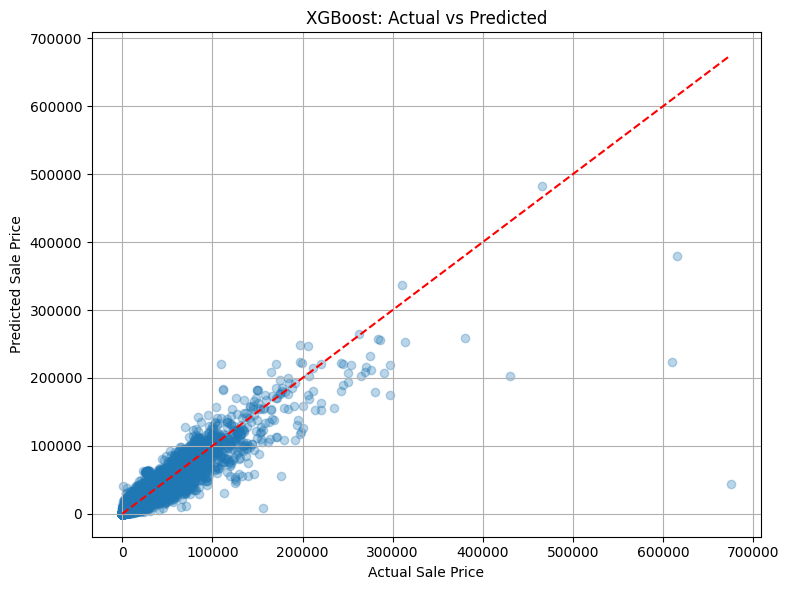

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, xgb_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('XGBoost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
import shap
import matplotlib.pyplot as plt

CatBoost

In [ ]:
# # === CatBoost + Optuna: 2-stage multi-fidelity tuner (ASHA; optional pruning callback) ===
# import os, sys, time, numpy as np, pandas as pd
# import optuna
# from optuna.trial import TrialState
# from optuna.pruners import SuccessiveHalvingPruner, HyperbandPruner
# from optuna.samplers import TPESampler
# from catboost import CatBoostRegressor, Pool, CatBoostError
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import mean_squared_error

# # Try to import the integration callback; fall back if unavailable
# try:
#     from optuna.integration import CatBoostPruningCallback  # requires optuna-integration[catboost]
#     HAS_CB_PRUNE = True
# except Exception:
#     CatBoostPruningCallback = None
#     HAS_CB_PRUNE = False
#     print("[INFO] optuna-integration[catboost] not found; continuing without CatBoostPruningCallback "
#           "(pruning will occur between folds, not during iterations).", flush=True)

# # ================= USER KNOBS =================
# TARGET = "VRSALEAMT"
# USE_GPU = False
# LOG_TARGET = True
# SEED = 42
# THREADS = max(1, os.cpu_count() // 2)

# # Data budgets (multi-fidelity)
# STAGE1_MAX_TRAIN_ROWS = 250_000     # tiny/cheap
# STAGE2_MAX_TRAIN_ROWS = 800_000     # bigger, still tractable
# FOLD_SAMPLE_FRAC_S1 = 0.08          # stronger downsample early
# FOLD_SAMPLE_FRAC_S2 = 0.20

# # Iteration budgets (multi-fidelity)
# STAGE1_ITERS_MIN, STAGE1_ITERS_MAX = 300, 900
# STAGE2_ITERS_MIN, STAGE2_ITERS_MAX = 800, 2000

# EARLY_STOP_ROUNDS = 100
# N_SPLITS = 3
# GAP_ROWS = 0

# # Trials
# STAGE1_TRIALS = 50
# STAGE2_TRIALS = 20

# # Search space (coarse; we’ll narrow in Stage 2)
# DEPTH_RANGE = (6, 10)
# L2_RANGE = (3.0, 40.0)
# LR_RANGE = (0.02, 0.12)
# MDL_RANGE = (512, 4096)
# SUBSAMPLE_RANGE = (0.6, 0.95)
# RSM_RANGE = (0.7, 0.95)
# RAND_STR_RANGE = (0.0, 0.8)

# # ============================================================
# # Prepare data (assumes df 'cars' with 'sale_date' + TARGET)
# assert "sale_date" in cars.columns, "Need 'sale_date' for time-aware CV."
# cars_sorted = cars.dropna(subset=["sale_date"]).sort_values("sale_date").reset_index(drop=True)

# feature_cols = [c for c in cars_sorted.columns if c not in [TARGET, "sale_date"]]
# X_all = cars_sorted[feature_cols].copy()
# y_all = cars_sorted[TARGET].astype("float32").copy()
# mask = y_all.notna()
# X_all = X_all.loc[mask].reset_index(drop=True)
# y_all = y_all.loc[mask].reset_index(drop=True)

# cat_cols = X_all.select_dtypes(include=["object", "category"]).columns.tolist()
# num_cols = X_all.select_dtypes(include=[np.number, "boolean"]).columns.tolist()
# if cat_cols:
#     X_all.loc[:, cat_cols] = X_all.loc[:, cat_cols].fillna("__MISSING__").astype(str)
# if num_cols:
#     X_all.loc[:, num_cols] = (
#         X_all.loc[:, num_cols]
#         .replace([np.inf, -np.inf], np.nan)
#         .apply(pd.to_numeric, errors="coerce", downcast="float")
#     )
# cat_idx = [X_all.columns.get_loc(c) for c in cat_cols]

# def _subset_df(X, y, frac, seed):
#     if frac >= 1.0: return X, y
#     idx = X.index.to_series().sample(frac=frac, random_state=seed).index
#     return X.loc[idx], y.loc[idx]

# def _cap_recent_rows(X, y, cap):
#     if cap is None or len(X) <= cap: return X, y
#     return X.iloc[-cap:], y.iloc[-cap:]

# def _fmt(d):
#     out = {}
#     for k, v in d.items():
#         out[k] = float(f"{v:.5g}") if isinstance(v, float) else v
#     return out

# def make_objective(max_train_rows, fold_frac, iters_min, iters_max, refine_from=None):
#     """
#     Build an objective with a given data + iteration budget.
#     refine_from: dict of center params to narrow around (from Stage 1 best).
#     """
#     def near(center, width, lo=None, hi=None):
#         lo2, hi2 = center - width, center + width
#         if lo is not None: lo2 = max(lo2, lo)
#         if hi is not None: hi2 = min(hi2, hi)
#         return lo2, hi2

#     def objective(trial):
#         # ----- Search space -----
#         if refine_from is None:
#             depth = trial.suggest_int("depth", *DEPTH_RANGE)
#             l2 = trial.suggest_float("l2_leaf_reg", *L2_RANGE, log=True)
#             lr = trial.suggest_float("learning_rate", *LR_RANGE, log=True)
#             mdl = trial.suggest_int("min_data_in_leaf", *MDL_RANGE)
#             rsm = trial.suggest_float("rsm", *RSM_RANGE)
#             subsample = trial.suggest_float("subsample", *SUBSAMPLE_RANGE)
#             rand_str = trial.suggest_float("random_strength", *RAND_STR_RANGE)
#         else:
#             depth0 = refine_from.get("depth", 8)
#             l20 = refine_from.get("l2_leaf_reg", 10.0)
#             lr0 = refine_from.get("learning_rate", 0.06)
#             mdl0 = refine_from.get("min_data_in_leaf", 1500)
#             rsm0 = refine_from.get("rsm", 0.8)
#             sub0 = refine_from.get("subsample", 0.8)
#             rs0  = refine_from.get("random_strength", 0.2)

#             depth = trial.suggest_int("depth", max(6, depth0-1), min(10, depth0+1))
#             l2_lo, l2_hi = near(l20, l20*0.7, L2_RANGE[0], L2_RANGE[1])
#             l2 = trial.suggest_float("l2_leaf_reg", max(L2_RANGE[0], l2_lo), min(L2_RANGE[1], l2_hi), log=True)
#             lr_lo, lr_hi = near(lr0, max(0.005, lr0*0.5), LR_RANGE[0], LR_RANGE[1])
#             lr = trial.suggest_float("learning_rate", lr_lo, lr_hi, log=True)
#             mdl_lo, mdl_hi = near(mdl0, max(200, mdl0*0.5), MDL_RANGE[0], MDL_RANGE[1])
#             mdl = trial.suggest_int("min_data_in_leaf", int(mdl_lo), int(mdl_hi))
#             rsm_lo, rsm_hi = near(rsm0, 0.1, RSM_RANGE[0], RSM_RANGE[1])
#             rsm = trial.suggest_float("rsm", rsm_lo, rsm_hi)
#             sub_lo, sub_hi = near(sub0, 0.1, SUBSAMPLE_RANGE[0], SUBSAMPLE_RANGE[1])
#             subsample = trial.suggest_float("subsample", sub_lo, sub_hi)
#             rs_lo, rs_hi = near(rs0, 0.2, RAND_STR_RANGE[0], RAND_STR_RANGE[1])
#             rand_str = trial.suggest_float("random_strength", rs_lo, rs_hi)

#         iterations = trial.suggest_int("iterations", iters_min, iters_max)

#         params = dict(
#             loss_function="RMSE",
#             eval_metric="RMSE",
#             depth=depth,
#             learning_rate=lr,
#             rsm=rsm,
#             l2_leaf_reg=l2,
#             random_strength=rand_str,
#             iterations=iterations,
#             od_type="Iter",
#             od_wait=EARLY_STOP_ROUNDS,
#             use_best_model=True,
#             min_data_in_leaf=mdl,
#             one_hot_max_size=12,
#             border_count=64,
#             random_state=SEED,
#             thread_count=THREADS,
#             verbose=False,     # we may attach pruning callback
#             task_type="GPU" if USE_GPU else "CPU",
#             bootstrap_type="Bernoulli",
#             subsample=subsample,
#             allow_writing_files=False,
#             boosting_type="Ordered",
#         )

#         tscv = TimeSeriesSplit(n_splits=N_SPLITS, gap=GAP_ROWS)
#         rmses = []

#         for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_all), start=1):
#             X_tr_raw, y_tr_raw = X_all.iloc[tr_idx], y_all.iloc[tr_idx]
#             X_val_raw, y_val_raw = X_all.iloc[val_idx], y_all.iloc[val_idx]

#             X_tr, y_tr = _subset_df(X_tr_raw, y_tr_raw, fold_frac, SEED + fold)
#             X_tr, y_tr = _cap_recent_rows(X_tr, y_tr, max_train_rows)
#             X_val, y_val = X_val_raw, y_val_raw

#             y_tr_fit = np.log1p(y_tr.values) if LOG_TARGET else y_tr.values
#             y_val_fit = np.log1p(y_val.values) if LOG_TARGET else y_val.values

#             train_pool = Pool(X_tr, label=y_tr_fit, cat_features=cat_idx)
#             valid_pool = Pool(X_val, label=y_val_fit, cat_features=cat_idx)

#             model = CatBoostRegressor(**params)

#             # Optional per-iteration pruning if integration is installed
#             kwargs = dict(
#                 verbose=False,
#                 early_stopping_rounds=EARLY_STOP_ROUNDS,
#             )
#             if HAS_CB_PRUNE:
#                 kwargs["callbacks"] = [CatBoostPruningCallback(trial, "RMSE")]

#             try:
#                 model.fit(train_pool, eval_set=valid_pool, **kwargs)
#             except (CatBoostError, MemoryError) as e:
#                 trial.set_user_attr("fit_error", str(e))
#                 # prune on OOM/alloc to keep study running
#                 raise optuna.exceptions.TrialPruned()

#             # Evaluate on original scale
#             y_pred_fit = model.predict(valid_pool)
#             y_pred = np.expm1(y_pred_fit) if LOG_TARGET else y_pred_fit
#             rmse = float(np.sqrt(mean_squared_error(y_val.values, y_pred)))
#             rmses.append(rmse)

#             # Report running mean so ASHA/Hyperband can prune between folds
#             trial.report(-np.mean(rmses), step=fold)
#             if trial.should_prune():
#                 raise optuna.exceptions.TrialPruned()

#         return -float(np.mean(rmses))

#     return objective

# def run_stage(n_trials, objective, pruner, study_name="catboost_tune"):
#     sampler = TPESampler(seed=SEED, n_startup_trials=8, multivariate=True, group=True)
#     study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name=study_name)
#     study.optimize(objective, n_trials=n_trials, n_jobs=1, gc_after_trial=True, show_progress_bar=True)
#     return study

# # ---------------- Stage 1: coarse, cheap (ASHA) ----------------
# asha = SuccessiveHalvingPruner(min_resource=1, reduction_factor=3, min_early_stopping_rate=0)
# obj_s1 = make_objective(
#     max_train_rows=STAGE1_MAX_TRAIN_ROWS,
#     fold_frac=FOLD_SAMPLE_FRAC_S1,
#     iters_min=STAGE1_ITERS_MIN,
#     iters_max=STAGE1_ITERS_MAX,
# )
# print("=== Stage 1 (coarse, cheap) ===", flush=True)
# study1 = run_stage(STAGE1_TRIALS, obj_s1, asha, "catboost_s1")

# best_params_s1 = {}
# if any(t.state == TrialState.COMPLETE for t in study1.trials):
#     best_params_s1 = study1.best_trial.params
#     print("Stage 1 best RMSE ~", round(-study1.best_value, 4), flush=True)
#     print("Stage 1 best params:", _fmt(best_params_s1), flush=True)
# else:
#     print("Stage 1 finished with all trials pruned; consider easing budgets.", flush=True)

# # ---------------- Stage 2: refine near Stage 1 winner (Hyperband) ----------------
# if best_params_s1:
#     hb = HyperbandPruner(min_resource=1, max_resource=STAGE2_ITERS_MAX, reduction_factor=3)
#     obj_s2 = make_objective(
#         max_train_rows=STAGE2_MAX_TRAIN_ROWS,
#         fold_frac=FOLD_SAMPLE_FRAC_S2,
#         iters_min=STAGE2_ITERS_MIN,
#         iters_max=STAGE2_ITERS_MAX,
#         refine_from=best_params_s1
#     )
#     print("\n=== Stage 2 (refine near Stage 1 winner) ===", flush=True)
#     study2 = run_stage(STAGE2_TRIALS, obj_s2, hb, "catboost_s2")

#     if any(t.state == TrialState.COMPLETE for t in study2.trials):
#         print("\n--- FINAL ---", flush=True)
#         print("Best CV RMSE:", round(-study2.best_value, 6), flush=True)
#         print("Best params:", _fmt(study2.best_params), flush=True)
#     else:
#         print("Stage 2 had no completed trials; fall back to Stage 1 winner.", flush=True)
# else:
#     print("\nNo Stage 1 winner; try relaxing budgets (raise STAGE1_MAX_TRAIN_ROWS, FOLD_SAMPLE_FRAC_S1, "
#           "or widen iteration ranges).", flush=True)

[INFO] optuna-integration[catboost] not found; continuing without CatBoostPruningCallback (pruning will occur between folds, not during iterations).
=== Stage 1 (coarse, cheap) ===


[I 2025-11-16 12:40:37,810] A new study created in memory with name: catboost_s1
  0%|          | 0/50 [30:08<?, ?it/s]

[I 2025-11-16 13:10:46,524] Trial 0 finished with value: -5130.277450892183 and parameters: {'depth': 7, 'l2_leaf_reg': 35.20599358045187, 'learning_rate': 0.07423898007815308, 'min_data_in_leaf': 2658, 'rsm': 0.7390046601106091, 'subsample': 0.6545980821176709, 'random_strength': 0.04646688973455957, 'iterations': 820}. Best is trial 0 with value: -5130.277450892183.


Best trial: 0. Best value: -5130.28:   2%|▏         | 1/50 [36:22<24:37:36, 1809.32s/it]

[I 2025-11-16 13:17:00,178] Trial 1 pruned. 


Best trial: 0. Best value: -5130.28:   4%|▍         | 2/50 [41:41<12:51:50, 964.80s/it] 

[I 2025-11-16 13:22:19,109] Trial 2 pruned. 


Best trial: 0. Best value: -5130.28:   6%|▌         | 3/50 [46:31<8:44:46, 669.93s/it] 

[I 2025-11-16 13:27:09,504] Trial 3 pruned. 


Best trial: 0. Best value: -5130.28:   8%|▊         | 4/50 [1:04:12<6:38:41, 520.03s/it]

[I 2025-11-16 13:44:49,863] Trial 4 pruned. 


Best trial: 0. Best value: -5130.28:  10%|█         | 5/50 [1:09:03<8:56:15, 715.00s/it]

[I 2025-11-16 13:49:41,264] Trial 5 pruned. 


Best trial: 0. Best value: -5130.28:  12%|█▏        | 6/50 [1:51:13<6:58:39, 570.89s/it]

[I 2025-11-16 14:31:51,673] Trial 6 finished with value: -5124.984783661547 and parameters: {'depth': 8, 'l2_leaf_reg': 4.842517427720273, 'learning_rate': 0.11363535842161894, 'min_data_in_leaf': 3290, 'rsm': 0.9348747353910473, 'subsample': 0.913189572649677, 'random_strength': 0.47831998304886814, 'iterations': 854}. Best is trial 6 with value: -5124.984783661547.


Best trial: 6. Best value: -5124.98:  14%|█▍        | 7/50 [1:55:15<14:28:10, 1211.41s/it]

[I 2025-11-16 14:35:53,563] Trial 7 pruned. 


Best trial: 6. Best value: -5124.98:  16%|█▌        | 8/50 [2:39:36<10:32:01, 902.90s/it] 

[I 2025-11-16 15:20:14,255] Trial 8 finished with value: -4960.979175024211 and parameters: {'depth': 8, 'l2_leaf_reg': 5.300284735765273, 'learning_rate': 0.06424865113353082, 'min_data_in_leaf': 3641, 'rsm': 0.9071990271071835, 'subsample': 0.9289674818194205, 'random_strength': 0.7106628390919755, 'iterations': 779}. Best is trial 8 with value: -4960.979175024211.


Best trial: 8. Best value: -4960.98:  18%|█▊        | 9/50 [2:50:18<16:32:23, 1452.28s/it]

[I 2025-11-16 15:30:55,851] Trial 9 pruned. 


Best trial: 8. Best value: -4960.98:  20%|██        | 10/50 [3:02:16<13:21:24, 1202.12s/it]

[I 2025-11-16 15:42:54,139] Trial 10 pruned. 


Best trial: 8. Best value: -4960.98:  22%|██▏       | 11/50 [3:33:02<11:25:07, 1054.04s/it]

[I 2025-11-16 16:13:40,553] Trial 11 pruned. 


Best trial: 8. Best value: -4960.98:  24%|██▍       | 12/50 [3:43:35<13:40:15, 1295.13s/it]

[I 2025-11-16 16:24:13,325] Trial 12 pruned. 


Best trial: 8. Best value: -4960.98:  26%|██▌       | 13/50 [4:24:04<11:14:54, 1094.43s/it]

[I 2025-11-16 17:04:42,741] Trial 13 finished with value: -5034.883475716983 and parameters: {'depth': 8, 'l2_leaf_reg': 3.6356399848250196, 'learning_rate': 0.1154354587844164, 'min_data_in_leaf': 4089, 'rsm': 0.9008060876573838, 'subsample': 0.9056775569241045, 'random_strength': 0.12243043197164205, 'iterations': 779}. Best is trial 8 with value: -4960.979175024211.


Best trial: 8. Best value: -4960.98:  28%|██▊       | 14/50 [4:51:38<14:58:32, 1497.56s/it]

[I 2025-11-16 17:32:16,584] Trial 14 pruned. 


Best trial: 8. Best value: -4960.98:  30%|███       | 15/50 [4:58:59<15:01:10, 1544.86s/it]

[I 2025-11-16 17:39:37,407] Trial 15 pruned. 


Best trial: 8. Best value: -4960.98:  32%|███▏      | 16/50 [5:09:45<11:27:04, 1212.48s/it]

[I 2025-11-16 17:50:23,686] Trial 16 pruned. 


Best trial: 8. Best value: -4960.98:  34%|███▍      | 17/50 [5:47:22<9:33:11, 1042.17s/it] 

[I 2025-11-16 18:28:00,250] Trial 17 finished with value: -4995.034154389486 and parameters: {'depth': 8, 'l2_leaf_reg': 3.6680369814364693, 'learning_rate': 0.10965098194753957, 'min_data_in_leaf': 4080, 'rsm': 0.9005036073862301, 'subsample': 0.8418077075190583, 'random_strength': 0.06418322964806666, 'iterations': 724}. Best is trial 8 with value: -4960.979175024211.


Best trial: 8. Best value: -4960.98:  36%|███▌      | 18/50 [5:53:54<12:30:24, 1407.00s/it]

[I 2025-11-16 18:34:31,933] Trial 18 pruned. 


Best trial: 8. Best value: -4960.98:  38%|███▊      | 19/50 [6:00:04<9:29:26, 1102.13s/it] 

[I 2025-11-16 18:40:41,931] Trial 19 pruned. 


Best trial: 8. Best value: -4960.98:  40%|████      | 20/50 [6:12:55<7:21:10, 882.33s/it] 

[I 2025-11-16 18:53:33,716] Trial 20 pruned. 


Best trial: 8. Best value: -4960.98:  42%|████▏     | 21/50 [6:21:04<6:50:26, 849.21s/it]

[I 2025-11-16 19:01:42,318] Trial 21 pruned. 


Best trial: 8. Best value: -4960.98:  44%|████▍     | 22/50 [7:02:06<5:45:47, 740.98s/it]

[I 2025-11-16 19:42:43,995] Trial 22 finished with value: -4903.440196975724 and parameters: {'depth': 7, 'l2_leaf_reg': 3.257035072277796, 'learning_rate': 0.10379793644291166, 'min_data_in_leaf': 3900, 'rsm': 0.9407386126444387, 'subsample': 0.838930101545174, 'random_strength': 0.04357533920558705, 'iterations': 865}. Best is trial 22 with value: -4903.440196975724.


Best trial: 22. Best value: -4903.44:  46%|████▌     | 23/50 [7:31:25<9:25:44, 1257.19s/it]

[I 2025-11-16 20:12:03,267] Trial 23 pruned. 


Best trial: 22. Best value: -4903.44:  48%|████▊     | 24/50 [7:40:03<10:10:08, 1408.03s/it]

[I 2025-11-16 20:20:41,663] Trial 24 pruned. 


Best trial: 22. Best value: -4903.44:  50%|█████     | 25/50 [7:46:13<7:55:26, 1141.04s/it] 

[I 2025-11-16 20:26:51,521] Trial 25 pruned. 


Best trial: 22. Best value: -4903.44:  52%|█████▏    | 26/50 [8:27:41<6:03:51, 909.63s/it] 

[I 2025-11-16 21:08:19,164] Trial 26 pruned. 


Best trial: 22. Best value: -4903.44:  54%|█████▍    | 27/50 [9:04:15<8:50:12, 1383.15s/it]

[I 2025-11-16 21:44:53,192] Trial 27 pruned. 


Best trial: 22. Best value: -4903.44:  56%|█████▌    | 28/50 [9:35:00<9:56:21, 1626.42s/it]

[I 2025-11-16 22:15:38,496] Trial 28 pruned. 


Best trial: 22. Best value: -4903.44:  58%|█████▊    | 29/50 [10:07:01<9:52:13, 1692.09s/it]

[I 2025-11-16 22:47:39,580] Trial 29 finished with value: -4953.880206820417 and parameters: {'depth': 7, 'l2_leaf_reg': 4.435350239589982, 'learning_rate': 0.10936963819389343, 'min_data_in_leaf': 4053, 'rsm': 0.7582206970281052, 'subsample': 0.8877649250204787, 'random_strength': 0.0182974391173049, 'iterations': 881}. Best is trial 22 with value: -4903.440196975724.


Best trial: 22. Best value: -4903.44:  60%|██████    | 30/50 [10:36:00<9:46:52, 1760.62s/it]

[I 2025-11-16 23:16:38,428] Trial 30 pruned. 


Best trial: 22. Best value: -4903.44:  62%|██████▏   | 31/50 [10:42:49<9:15:30, 1754.22s/it]

[I 2025-11-16 23:23:26,940] Trial 31 pruned. 


Best trial: 22. Best value: -4903.44:  64%|██████▍   | 32/50 [11:19:07<6:45:08, 1350.50s/it]

[I 2025-11-16 23:59:44,833] Trial 32 pruned. 


Best trial: 22. Best value: -4903.44:  66%|██████▌   | 33/50 [11:54:09<7:32:58, 1598.76s/it]

[I 2025-11-17 00:34:47,760] Trial 33 finished with value: -4931.198214571871 and parameters: {'depth': 7, 'l2_leaf_reg': 4.734350492608822, 'learning_rate': 0.09333071155549082, 'min_data_in_leaf': 3695, 'rsm': 0.8208819677667458, 'subsample': 0.8096982214299149, 'random_strength': 0.2085910185458258, 'iterations': 897}. Best is trial 22 with value: -4903.440196975724.


Best trial: 22. Best value: -4903.44:  68%|██████▊   | 34/50 [12:00:51<7:46:37, 1749.83s/it]

[I 2025-11-17 00:41:29,419] Trial 34 pruned. 


Best trial: 22. Best value: -4903.44:  70%|███████   | 35/50 [12:07:56<5:36:22, 1345.52s/it]

[I 2025-11-17 00:48:33,208] Trial 35 pruned. 


Best trial: 22. Best value: -4903.44:  72%|███████▏  | 36/50 [12:31:53<4:09:25, 1068.98s/it]

[I 2025-11-17 01:12:31,191] Trial 36 pruned. 


Best trial: 22. Best value: -4903.44:  74%|███████▍  | 37/50 [12:42:09<4:15:36, 1179.74s/it]

[I 2025-11-17 01:22:46,990] Trial 37 pruned. 


Best trial: 22. Best value: -4903.44:  76%|███████▌  | 38/50 [12:52:55<3:22:06, 1010.51s/it]

[I 2025-11-17 01:33:32,955] Trial 38 pruned. 


Best trial: 22. Best value: -4903.44:  78%|███████▊  | 39/50 [13:25:58<2:45:12, 901.13s/it] 

[I 2025-11-17 02:06:36,105] Trial 39 finished with value: -4920.287896361794 and parameters: {'depth': 7, 'l2_leaf_reg': 5.713036062363697, 'learning_rate': 0.11767994405268059, 'min_data_in_leaf': 3631, 'rsm': 0.771641898336208, 'subsample': 0.9363421115853744, 'random_strength': 0.2528955004658112, 'iterations': 899}. Best is trial 22 with value: -4903.440196975724.


Best trial: 22. Best value: -4903.44:  80%|████████  | 40/50 [14:03:53<3:24:16, 1225.63s/it]

[I 2025-11-17 02:44:31,145] Trial 40 finished with value: -4966.259311883045 and parameters: {'depth': 7, 'l2_leaf_reg': 12.272858698087896, 'learning_rate': 0.09624670840721287, 'min_data_in_leaf': 3490, 'rsm': 0.791560343274435, 'subsample': 0.9241665184855004, 'random_strength': 0.3233045728686608, 'iterations': 879}. Best is trial 22 with value: -4903.440196975724.


Best trial: 22. Best value: -4903.44:  82%|████████▏ | 41/50 [14:11:42<3:51:03, 1540.44s/it]

[I 2025-11-17 02:52:20,278] Trial 41 pruned. 


Best trial: 22. Best value: -4903.44:  84%|████████▍ | 42/50 [14:36:20<2:42:33, 1219.18s/it]

[I 2025-11-17 03:16:57,846] Trial 42 pruned. 


Best trial: 22. Best value: -4903.44:  86%|████████▌ | 43/50 [15:10:58<2:31:17, 1296.77s/it]

[I 2025-11-17 03:51:36,277] Trial 43 finished with value: -4863.052561827042 and parameters: {'depth': 7, 'l2_leaf_reg': 7.075899863503776, 'learning_rate': 0.11789208819061249, 'min_data_in_leaf': 3888, 'rsm': 0.780306709263556, 'subsample': 0.8510385208105443, 'random_strength': 0.027108604040764664, 'iterations': 863}. Best is trial 43 with value: -4863.052561827042.


Best trial: 43. Best value: -4863.05:  88%|████████▊ | 44/50 [15:19:13<2:33:06, 1531.07s/it]

[I 2025-11-17 03:59:51,395] Trial 44 pruned. 


Best trial: 43. Best value: -4863.05:  90%|█████████ | 45/50 [15:47:44<1:41:41, 1220.38s/it]

[I 2025-11-17 04:28:21,852] Trial 45 pruned. 


Best trial: 43. Best value: -4863.05:  92%|█████████▏| 46/50 [16:18:41<1:31:09, 1367.47s/it]

[I 2025-11-17 04:59:19,093] Trial 46 pruned. 


Best trial: 43. Best value: -4863.05:  94%|█████████▍| 47/50 [16:49:39<1:15:43, 1514.40s/it]

[I 2025-11-17 05:30:17,740] Trial 47 pruned. 


Best trial: 43. Best value: -4863.05:  96%|█████████▌| 48/50 [16:56:03<53:55, 1617.72s/it]  

[I 2025-11-17 05:36:41,528] Trial 48 pruned. 


Best trial: 43. Best value: -4863.05:  98%|█████████▊| 49/50 [17:20:49<20:47, 1247.45s/it]

[I 2025-11-17 06:01:26,918] Trial 49 finished with value: -4953.722465626278 and parameters: {'depth': 7, 'l2_leaf_reg': 8.715271185720114, 'learning_rate': 0.11288653659429672, 'min_data_in_leaf': 3743, 'rsm': 0.774211322129483, 'subsample': 0.8186442276892788, 'random_strength': 0.06971688838597315, 'iterations': 898}. Best is trial 43 with value: -4863.052561827042.


Best trial: 43. Best value: -4863.05: 100%|██████████| 50/50 [17:20:49<00:00, 1248.99s/it]

Stage 1 best RMSE ~ 4863.0526
Stage 1 best params: {'depth': 7, 'l2_leaf_reg': 7.0759, 'learning_rate': 0.11789, 'min_data_in_leaf': 3888, 'rsm': 0.78031, 'subsample': 0.85104, 'random_strength': 0.027109, 'iterations': 863}

=== Stage 2 (refine near Stage 1 winner) ===



[I 2025-11-17 06:01:27,233] A new study created in memory with name: catboost_s2
  0%|          | 0/20 [1:17:14<?, ?it/s]

[I 2025-11-17 07:18:41,250] Trial 0 finished with value: -4784.6735180407395 and parameters: {'depth': 7, 'l2_leaf_reg': 11.233263265903473, 'learning_rate': 0.09918377913432978, 'min_data_in_leaf': 3232, 'rsm': 0.7281312076419496, 'subsample': 0.7820754213220849, 'random_strength': 0.013191288077164952, 'iterations': 1840}. Best is trial 0 with value: -4784.6735180407395.


Best trial: 0. Best value: -4784.67:   5%|▌         | 1/20 [2:33:34<24:27:32, 4634.35s/it]

[I 2025-11-17 08:35:01,431] Trial 1 finished with value: -4747.238569615686 and parameters: {'depth': 7, 'l2_leaf_reg': 8.019853652021972, 'learning_rate': 0.05981493638658641, 'min_data_in_leaf': 4032, 'rsm': 0.8500949932133884, 'subsample': 0.7932858243608677, 'random_strength': 0.04129401448216243, 'iterations': 1020}. Best is trial 1 with value: -4747.238569615686.


Best trial: 1. Best value: -4747.24:  10%|█         | 2/20 [3:33:31<23:00:44, 4602.49s/it]

[I 2025-11-17 09:34:58,424] Trial 2 finished with value: -4781.221990184255 and parameters: {'depth': 6, 'l2_leaf_reg': 6.217370703389233, 'learning_rate': 0.08013229360330842, 'min_data_in_leaf': 2571, 'rsm': 0.8103211820007732, 'subsample': 0.7787924256637224, 'random_strength': 0.06634856330681321, 'iterations': 1240}. Best is trial 1 with value: -4747.238569615686.


Best trial: 1. Best value: -4747.24:  15%|█▌        | 3/20 [4:49:59<19:33:59, 4143.53s/it]

[I 2025-11-17 10:51:26,611] Trial 3 finished with value: -4729.147071092005 and parameters: {'depth': 7, 'l2_leaf_reg': 8.926232906690498, 'learning_rate': 0.06793588992444571, 'min_data_in_leaf': 3051, 'rsm': 0.8068163214313031, 'subsample': 0.7602803636342758, 'random_strength': 0.13797866320748878, 'iterations': 1004}. Best is trial 3 with value: -4729.147071092005.


Best trial: 3. Best value: -4729.15:  20%|██        | 4/20 [6:06:44<19:11:49, 4319.34s/it]

[I 2025-11-17 12:08:11,316] Trial 4 finished with value: -4706.355851390119 and parameters: {'depth': 6, 'l2_leaf_reg': 11.204771116371068, 'learning_rate': 0.11710378733220957, 'min_data_in_leaf': 3684, 'rsm': 0.7549239063160189, 'subsample': 0.7704715090888157, 'random_strength': 0.15539520748976346, 'iterations': 1328}. Best is trial 4 with value: -4706.355851390119.


Best trial: 4. Best value: -4706.36:  25%|██▌       | 5/20 [6:21:36<18:25:34, 4422.27s/it]

[I 2025-11-17 12:23:03,802] Trial 5 pruned. 


Best trial: 4. Best value: -4706.36:  30%|███       | 6/20 [7:39:54<12:31:49, 3222.14s/it]

[I 2025-11-17 13:41:21,280] Trial 6 finished with value: -4687.430834161069 and parameters: {'depth': 7, 'l2_leaf_reg': 3.878008032487924, 'learning_rate': 0.11743328566006701, 'min_data_in_leaf': 3612, 'rsm': 0.8693979625100329, 'subsample': 0.9290746940708107, 'random_strength': 0.13578822954378833, 'iterations': 1907}. Best is trial 6 with value: -4687.430834161069.


Best trial: 6. Best value: -4687.43:  35%|███▌      | 7/20 [8:47:49<13:22:37, 3704.46s/it]

[I 2025-11-17 14:49:16,718] Trial 7 pruned. 


Best trial: 6. Best value: -4687.43:  40%|████      | 8/20 [10:40:12<12:44:42, 3823.50s/it]

[I 2025-11-17 16:41:39,568] Trial 8 finished with value: -4562.282819280796 and parameters: {'depth': 7, 'l2_leaf_reg': 4.070426105085773, 'learning_rate': 0.09365648456211052, 'min_data_in_leaf': 3823, 'rsm': 0.8494374989612264, 'subsample': 0.9380438259191793, 'random_strength': 0.20174705666228138, 'iterations': 1758}. Best is trial 8 with value: -4562.282819280796.


Best trial: 8. Best value: -4562.28:  45%|████▌     | 9/20 [11:09:51<14:28:06, 4735.09s/it]

[I 2025-11-17 17:11:18,433] Trial 9 pruned. 


Best trial: 8. Best value: -4562.28:  50%|█████     | 10/20 [11:19:59<10:37:04, 3822.50s/it]

[I 2025-11-17 17:21:26,661] Trial 10 pruned. 


Best trial: 8. Best value: -4562.28:  55%|█████▌    | 11/20 [12:24:14<7:05:47, 2838.63s/it] 

[I 2025-11-17 18:25:41,655] Trial 11 finished with value: -4648.979009283471 and parameters: {'depth': 7, 'l2_leaf_reg': 3.515364042980033, 'learning_rate': 0.1107062793785104, 'min_data_in_leaf': 3918, 'rsm': 0.8259070518138909, 'subsample': 0.9247741026849631, 'random_strength': 0.1890095737183173, 'iterations': 1728}. Best is trial 8 with value: -4562.282819280796.


Best trial: 8. Best value: -4562.28:  60%|██████    | 12/20 [12:46:37<6:59:41, 3147.68s/it]

[I 2025-11-17 18:48:04,944] Trial 12 pruned. 


Best trial: 8. Best value: -4562.28:  65%|██████▌   | 13/20 [12:53:46<5:03:28, 2601.24s/it]

[I 2025-11-17 18:55:13,911] Trial 13 pruned. 


Best trial: 8. Best value: -4562.28:  70%|███████   | 14/20 [13:07:58<3:14:30, 1945.05s/it]

[I 2025-11-17 19:09:25,741] Trial 14 pruned. 


Best trial: 8. Best value: -4562.28:  75%|███████▌  | 15/20 [14:11:18<2:14:37, 1615.56s/it]

[I 2025-11-17 20:12:45,398] Trial 15 finished with value: -4603.9319475939155 and parameters: {'depth': 8, 'l2_leaf_reg': 3.6481185464736035, 'learning_rate': 0.10902901545033888, 'min_data_in_leaf': 3846, 'rsm': 0.7734013161062611, 'subsample': 0.8563433452905619, 'random_strength': 0.20392961813010252, 'iterations': 1747}. Best is trial 8 with value: -4562.282819280796.


Best trial: 8. Best value: -4562.28:  80%|████████  | 16/20 [14:21:41<2:31:31, 2272.83s/it]

[I 2025-11-17 20:23:08,559] Trial 16 pruned. 


Best trial: 8. Best value: -4562.28:  85%|████████▌ | 17/20 [15:28:01<1:28:50, 1776.89s/it]

[I 2025-11-17 21:29:28,549] Trial 17 finished with value: -4703.8116257314405 and parameters: {'depth': 8, 'l2_leaf_reg': 3.3242664761352683, 'learning_rate': 0.10237590115679789, 'min_data_in_leaf': 3621, 'rsm': 0.7787440379528655, 'subsample': 0.8370054141242761, 'random_strength': 0.2254404180199952, 'iterations': 1382}. Best is trial 8 with value: -4562.282819280796.


Best trial: 8. Best value: -4562.28:  90%|█████████ | 18/20 [16:07:30<1:21:17, 2438.78s/it]

[I 2025-11-17 22:08:58,225] Trial 18 finished with value: -4710.791604104507 and parameters: {'depth': 7, 'l2_leaf_reg': 3.170070245610041, 'learning_rate': 0.11562318148050077, 'min_data_in_leaf': 4068, 'rsm': 0.7284400981361775, 'subsample': 0.8595881551683039, 'random_strength': 0.17960751723692023, 'iterations': 1809}. Best is trial 8 with value: -4562.282819280796.


Best trial: 8. Best value: -4562.28:  95%|█████████▌| 19/20 [16:16:26<40:18, 2418.01s/it]  

[I 2025-11-17 22:17:53,241] Trial 19 pruned. 


Best trial: 8. Best value: -4562.28: 100%|██████████| 20/20 [16:16:26<00:00, 2929.33s/it]


--- FINAL ---
Best CV RMSE: 4562.282819
Best params: {'depth': 7, 'l2_leaf_reg': 4.0704, 'learning_rate': 0.093656, 'min_data_in_leaf': 3823, 'rsm': 0.84944, 'subsample': 0.93804, 'random_strength': 0.20175, 'iterations': 1758}


In [ ]:
from catboost import CatBoostRegressor
catboost_model = CatBoostRegressor(
    iterations= 1758,
    learning_rate= 0.093656,
    depth= int(7.0),
    rsm= 0.84944,
    l2_leaf_reg= 4.0704,
    random_strength = 0.20175,
    min_data_in_leaf = 3823,
    subsample = 0.93804,
    bootstrap_type = 'Bernoulli',
    loss_function='RMSE',
    verbose=0,
    random_state=42,
)

In [ ]:
from sklearn.pipeline import Pipeline

catboost_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('catboost', catboost_model)
])

catboost_pipeline_ttr = with_log_target(catboost_pipeline)

In [ ]:
# Fit the pipeline
catboost_pipeline_ttr.fit(X_train, y_train)

# Predict on test data
catboost_preds = catboost_pipeline_ttr.predict(X_test)
catboost_preds_external = catboost_pipeline_ttr.predict(X_external)

In [ ]:
catboost_r2 = r2_score(y_test, catboost_preds)
catboost_mae = mean_absolute_error(y_test, catboost_preds)
catboost_mse = mean_squared_error(y_test, catboost_preds)
catboost_rmse = np.sqrt(catboost_mse)
catboost_mape = mean_absolute_percentage_error(y_test, catboost_preds)

# Display results
print("📊 catboost Regression Evaluation Metrics")
print(f"R² Score  : {catboost_r2:.4f}")
print(f"MAE       : {catboost_mae:.2f}")
print(f"MSE       : {catboost_mse:.2f}")
print(f"RMSE      : {catboost_rmse:.2f}")
print(f"MAPE      : {catboost_mape:.2%}")

📊 catboost Regression Evaluation Metrics
R² Score  : 0.9217
MAE       : 1660.80
MSE       : 11536419.20
RMSE      : 3396.53
MAPE      : 31.40%


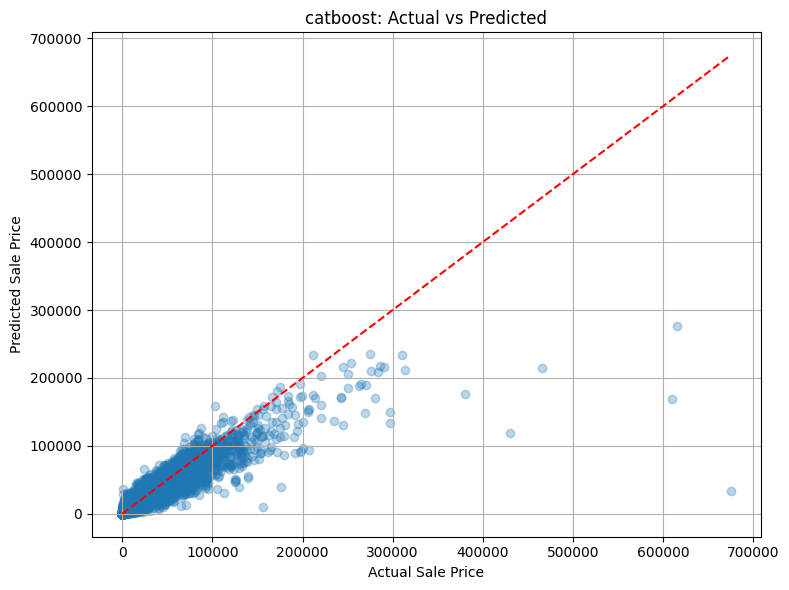

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, catboost_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('catboost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

CatBoost Native Handling

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
categorical_feats = list(pd.Index(categorical_feats).unique())
numeric_feats     = list(pd.Index(numeric_feats).unique())
all_feats         = categorical_feats + numeric_feats  # order matters for indices

In [ ]:
X_train_all    = X_train[all_feats].copy()
X_test_all     = X_test[all_feats].copy()
X_external_all = X_external[all_feats].copy()

In [ ]:
# 2) Fill/convert categorical columns on ALL splits
def prep_cats(df, cat_cols):
    # Fill NaN, then cast to string/object (CatBoost wants strings/ints, not floats/NaN)
    df[cat_cols] = df[cat_cols].fillna('Unknown').astype(str)
    return df

X_train_all    = prep_cats(X_train_all,    categorical_feats)
X_test_all     = prep_cats(X_test_all,     categorical_feats)
X_external_all = prep_cats(X_external_all, categorical_feats)

In [ ]:
# 3) Cat feature indices must match the columns you pass into Pool
cat_feature_indices = [all_feats.index(c) for c in categorical_feats]

# 4) Train on log-target and predict
y_train_log = np.log1p(y_train)

train_pool = Pool(X_train_all, y_train_log, cat_features=cat_feature_indices)
test_pool  = Pool(X_test_all,  cat_features=cat_feature_indices)
ext_pool   = Pool(X_external_all, cat_features=cat_feature_indices)

In [ ]:
cat_model = CatBoostRegressor(
    iterations= 1758,
    learning_rate= 0.093656,
    depth= int(7.0),
    rsm= 0.84944,
    l2_leaf_reg= 4.0704,
    random_strength = 0.20175,
    min_data_in_leaf = 3823,
    subsample = 0.93804,
    bootstrap_type = 'Bernoulli',
    loss_function='RMSE',
    verbose=0,
    random_state=42,
)

cat_model.fit(train_pool)

In [ ]:
cat_log_preds          = cat_model.predict(test_pool)
cat_preds              = np.expm1(cat_log_preds)

cat_log_preds_external = cat_model.predict(ext_pool)
cat_preds_external     = np.expm1(cat_log_preds_external)

In [ ]:
cat_r2 = r2_score(y_test, cat_preds)
cat_mae = mean_absolute_error(y_test, cat_preds)
cat_mse = mean_squared_error(y_test, cat_preds)
cat_rmse = np.sqrt(cat_mse)
cat_mape = mean_absolute_percentage_error(y_test, cat_preds)

# Display results
print("📊 catboost Regression Evaluation Metrics")
print(f"R² Score  : {cat_r2:.4f}")
print(f"MAE       : {cat_mae:.2f}")
print(f"MSE       : {cat_mse:.2f}")
print(f"RMSE      : {cat_rmse:.2f}")
print(f"MAPE      : {cat_mape:.2%}")

📊 catboost Regression Evaluation Metrics
R² Score  : 0.9087
MAE       : 1770.53
MSE       : 13455055.41
RMSE      : 3668.11
MAPE      : 34.59%


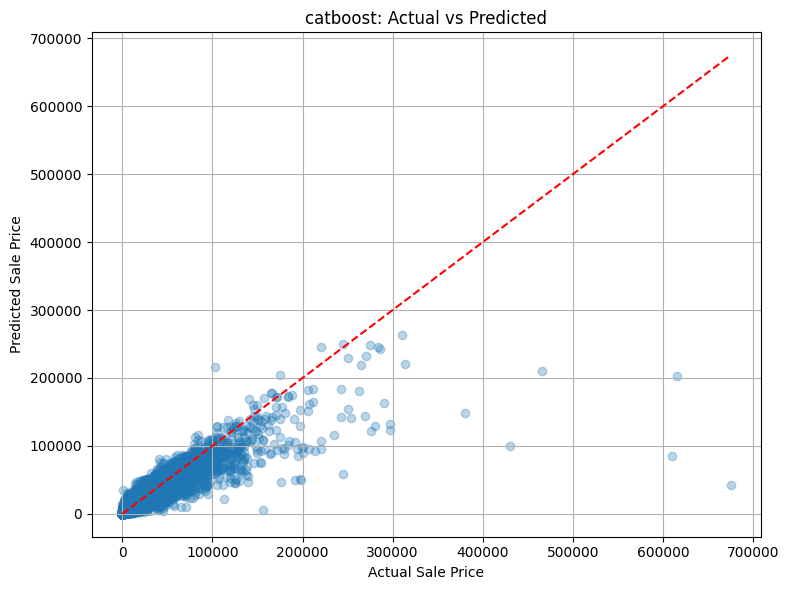

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, cat_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('catboost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

Model Combination

In [ ]:
import os
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.isotonic import IsotonicRegression
from scipy.optimize import nnls

from sklearn.base import BaseEstimator, RegressorMixin, clone

import optuna
from optuna.samplers import TPESampler

In [ ]:
# Define the base models with fixed parameters
catboost_model = CatBoostRegressor(
    iterations= 1758,
    learning_rate= 0.093656,
    depth= int(7.0),
    rsm= 0.84944,
    l2_leaf_reg= 4.0704,
    random_strength = 0.20175,
    min_data_in_leaf = 3823,
    subsample = 0.93804,
    bootstrap_type = 'Bernoulli',
    loss_function='RMSE',
    verbose=0,
    random_state=42,
)

xgb_model = XGBRegressor(
    # fixed hyperparameters from BayesOpt:
    max_depth=10,
    learning_rate=0.21245910053249895,
    subsample=0.8023816022011749,
    colsample_bytree=0.538889024654892,
    gamma=2.1537703839033284,
    min_child_weight=3,
    reg_alpha=0.914666448962566,
    reg_lambda=4.265359935084676,
    # keep the rest as before:
    objective='reg:squarederror',
    eval_metric='rmse',
    use_label_encoder=False,
    random_state=0,
    n_estimators=200,
    n_jobs=-1
)

In [ ]:
# 1) LOG-TARGET WRAPPER (for whole pipeline)
# ==================================================

class LogTargetWrapper(BaseEstimator, RegressorMixin):
    """Wrap any regressor so it trains on log1p(y) and predicts on the original scale."""
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator

    def fit(self, X, y):
        self.est_ = clone(self.base_estimator)
        y_log = np.log1p(np.asarray(y, dtype=float).ravel())
        self.est_.fit(X, y_log)
        return self

    def predict(self, X):
        y_log_pred = self.est_.predict(X)
        return np.expm1(y_log_pred)

def with_log_target(est):
    return LogTargetWrapper(est)

In [ ]:
# 2) DEFINE STACKED MODEL (CatBoost + XGB + Ridge meta)
# ==================================================

meta = make_pipeline(
    StandardScaler(with_mean=False),
    Ridge(alpha=1.0, random_state=42)
)

stack = StackingRegressor(
    estimators=[('cat', catboost_model), ('xgb', xgb_model)],
    final_estimator=meta,
    passthrough=True,   # we might tune this later
    cv=5,
    n_jobs=1            # keep this 1 to avoid weirdness on Windows
)

stacking_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('stack',   stack),
])

stack_log = with_log_target(stacking_pipeline)

In [ ]:
# 3) RAW ROBUST MODEL (LightGBM if available, else HGB)
# ==================================================

try:
    from lightgbm import LGBMRegressor

    raw_model = Pipeline([
        ('preproc', preprocessor),
        ('lgb', LGBMRegressor(
            objective='huber',
            n_estimators=4000,
            learning_rate=0.03,
            num_leaves=63,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1,
        ))
    ])
except Exception:
    # Fallback: HistGradientBoostingRegressor on raw target
    raw_model = Pipeline([
        ('preproc', preprocessor),
        ('hgb', HistGradientBoostingRegressor(
            loss='absolute_error',
            max_iter=800,
            learning_rate=0.05,
            random_state=42,
        ))
    ])


In [ ]:
# 4) SPLIT TRAIN -> BASE TRAIN + BLEND-VALID (no test leakage)
# ==================================================

# Keep order if time-series like, so shuffle=False
X_train_base, X_blend, y_train_base, y_blend = train_test_split(
    X_train, y_train,
    test_size=0.1,
    shuffle=False
)

In [ ]:
# 5) FIT STACK (log-target) & RAW on BASE TRAIN ONLY
# ==================================================

stack_log_fitted = clone(stack_log)
stack_log_fitted.fit(X_train_base, y_train_base)

raw_fitted = clone(raw_model)
raw_fitted.fit(X_train_base, y_train_base)

In [ ]:
# 6) GET BLEND VALIDATION PREDICTIONS + LEARN WEIGHTS (NNLS)
# ==================================================

p_stack_blend = stack_log_fitted.predict(X_blend)  # already back on original scale
p_raw_blend   = raw_fitted.predict(X_blend)

P_blend = np.column_stack([p_stack_blend, p_raw_blend])
w, _ = nnls(P_blend, np.asarray(y_blend, dtype=float))
w = w / w.sum()   # normalize

print(f"Blend weights -> stack_log: {w[0]:.3f} | raw_robust: {w[1]:.3f}")

p_blend_blend = P_blend @ w

# Monotone calibration (isotonic), fit on blend fold
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_blend_blend, y_blend)

In [ ]:
# 7) EVALUATE ON TEST SET (HONEST, NO LEAKAGE)
# ==================================================

def report_metrics(name, y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float).ravel()
    y_pred = np.asarray(y_pred, dtype=float).ravel()
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name}")
    print(f"  R²   : {r2_score(y_true, y_pred):.4f}")
    print(f"  MAE  : {mean_absolute_error(y_true, y_pred):,.2f}")
    print(f"  RMSE : {rmse:,.2f}")
    print(f"  MAPE : {mean_absolute_percentage_error(y_true, y_pred):.2%}")
    print("-" * 50)

# Single models
p_cat_test  = stacking_pipeline.named_steps['stack'].estimators_[0].fit(
    preprocessor.fit_transform(X_train), np.log1p(y_train)  # NOTE: only if you want a clean cat-only model here
)
# ^ If you already have separate native-cat CatBoost, you can instead reuse that.

# For the stack & raw:
p_stack_test = stack_log_fitted.predict(X_test)
p_raw_test   = raw_fitted.predict(X_test)

P_test = np.column_stack([p_stack_test, p_raw_test])
p_blend_test = P_test @ w
p_blend_cal_test = iso.transform(p_blend_test)

print("=== TEST METRICS ===")
report_metrics("Stack (log)", y_test, p_stack_test)
report_metrics("Raw robust", y_test, p_raw_test)
report_metrics("Blend", y_test, p_blend_test)
report_metrics("Blend + Isotonic", y_test, p_blend_cal_test)

In [ ]:
# FINAL PREDICTIONS — SAME VARIABLE NAMES YOU USE
# ==================================================

# --- Test set ---
p_stack_test = stack_log_fitted.predict(X_test)
p_raw_test   = raw_fitted.predict(X_test)

P_test = np.column_stack([p_stack_test, p_raw_test])
p_blend_test = P_test @ w
p_blend_cal_test = iso.transform(p_blend_test)

# Your preferred naming:
y_pred = p_blend_cal_test  # FINAL BEST PREDICTIONS ON TEST


# --- External set ---
p_stack_ext = stack_log_fitted.predict(X_external)
p_raw_ext   = raw_fitted.predict(X_external)

P_ext = np.column_stack([p_stack_ext, p_raw_ext])
p_blend_ext = P_ext @ w
p_blend_cal_ext = iso.transform(p_blend_ext)

# Your preferred naming:
y_pred_external = p_blend_cal_ext  # FINAL BEST PREDICTIONS ON EXTERNAL


# ==================================================
# PRINT METRICS (OPTIONAL)
# ==================================================
print("Final Test Metrics:")
print("R²  :", r2_score(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

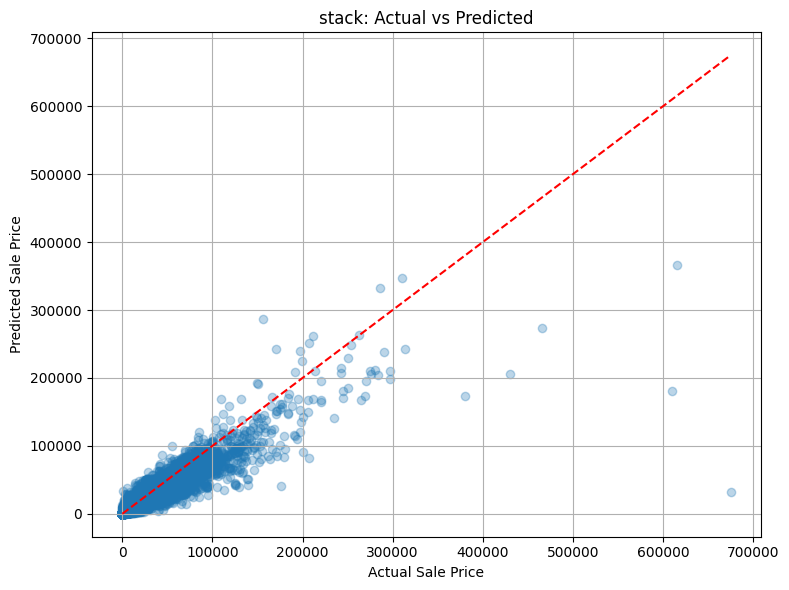

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('stack: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 9) OPTIONAL: LIGHT OPTUNA TUNING OF META (Ridge alpha + passthrough)
# ==================================================

RUN_OPTUNA = False   # flip to True if you want to run this

if RUN_OPTUNA:
    # Use a smaller subset for speed, if dataset is huge
    SUB_FRAC = 0.25
    if len(X_train) > 200_000:
        sub_idx = np.random.RandomState(42).choice(
            np.arange(len(X_train)), size=int(len(X_train)*SUB_FRAC), replace=False
        )
        X_tune = X_train.iloc[sub_idx]
        y_tune = y_train.iloc[sub_idx]
    else:
        X_tune, y_tune = X_train, y_train

    def optuna_objective(trial):
        alpha = trial.suggest_float("alpha", 1e-3, 1e2, log=True)
        passthrough = trial.suggest_categorical("passthrough", [True, False])

        meta_tuned = make_pipeline(
            StandardScaler(with_mean=False),
            Ridge(alpha=alpha, random_state=42)
        )

        stack_tuned = StackingRegressor(
            estimators=[('cat', catboost_model), ('xgb', xgb_model)],
            final_estimator=meta_tuned,
            passthrough=passthrough,
            cv=3,
            n_jobs=1
        )

        pipe_tuned = Pipeline([
            ('preproc', preprocessor),
            ('stack', stack_tuned),
        ])

        est = with_log_target(pipe_tuned)

        # 3-fold CV on tuning subset, optimize RMSE
        scores = cross_val_score(
            est, X_tune, y_tune,
            cv=3,
            scoring="neg_root_mean_squared_error",
            n_jobs=1
        )
        return -scores.mean()  # minimize RMSE

    sampler = TPESampler(seed=42, multivariate=True, group=True)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(optuna_objective, n_trials=20, show_progress_bar=True)

    print("\n=== OPTUNA META TUNING RESULTS ===")
    print(f"Best CV RMSE: {study.best_value:.4f}")
    print("Best params:", study.best_params)
    # You can then plug study.best_params["alpha"], ["passthrough"] back into the
    # meta and stack definitions above and re-run the fit/blend/calibration steps.


Visualize the actual prices and Predicted prices

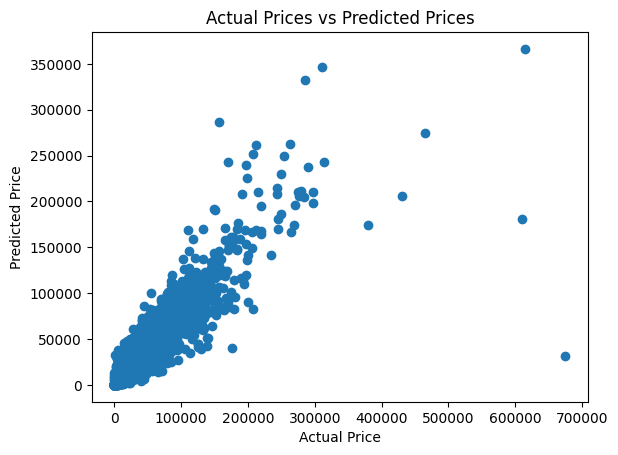

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Prices vs Predicted Prices")
plt.show()

Final Model Evaluation

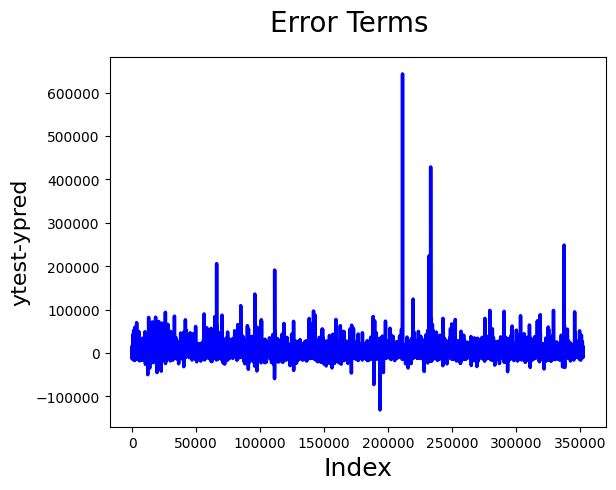

In [ ]:
# Error terms
c = [i for i in range(len(y_pred))]
fig = plt.figure()
plt.plot(c,y_test-y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label
plt.show()

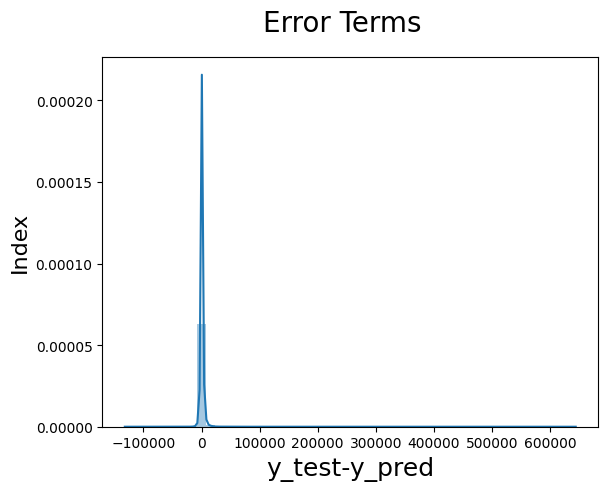

In [ ]:
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label
plt.show()

Export the Predictions

In [ ]:
# 1) Extract the true y values for X_external
y_external = cars_test['VRSALEAMT']

# 2) Compute R² for each model
r2_xgb      = r2_score(y_external, xgb_predictions_external)
r2_catboost = r2_score(y_external, catboost_preds_external)
r2_Cat_Native = r2_score(y_external, cat_preds_external)
r2_stack    = r2_score(y_external, y_pred_external)
r2_Blend    = r2_score(y_external, p_blend_cal_ext)

# 3) Print results
print(f"XGBoost external R²:      {r2_xgb:.4f}")
print(f"CatBoost external R²:     {r2_catboost:.4f}")
print(f"CatBoost Native R²:     {r2_Cat_Native:.4f}")
print(f"Stacked model external R²:{r2_stack:.4f}")
print(f"Blended model external R²:{r2_Blend:.4f}")

XGBoost external R²:      0.9290
CatBoost external R²:     0.8615
CatBoost Native R²:     0.9025
Stacked model external R²:0.8915
Blended model external R²:0.9160


In [ ]:
# # Create a DataFrame with the original prices and the predicted sales prices
# result_df = pd.DataFrame({
#     'SoldPrice': y_test,  # Original prices from y_test
#     'XGB_Predictions': xgb_predictions,
#     'RF_Predictions': rf_predictions,
#     'Stacked_Predictions': y_pred
# })
1
result_df = pd.DataFrame({
    'XGB_Predictions': xgb_predictions_external,
    'CatBoost_Predictions': catboost_preds_external,
    'CatBoost_Native_Predictions': cat_preds_external,
    'Stacked_Predictions': y_pred_external,
    'Blended_Calibrated': p_blend_cal_ext
})

final_df = pd.concat([cars_test_original.reset_index(drop=True), result_df.reset_index(drop=True)], axis=1)

# Export the DataFrame to a CSV file
final_df.to_excel('AAA Test.xlsx', sheet_name='sheet 1', index=False)